<a href="https://colab.research.google.com/github/matipasse/Trabajo-Final/blob/main/Trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link a la base: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?utm_source=chatgpt.com

#**Objetivo del análisis (resumen):**
Este trabajo busca evaluar la viabilidad operativa y económica de montar un hub logístico de e-commerce usando el dataset de Olist (Brasil) como ancla empírica. Partimos de una línea base determinista para construir los flujos de caja y métricas operativas; luego incorporamos incertidumbre mediante Simulación Monte Carlo (demanda, tarifas, costos, tiempos, TCC), aplicamos métodos numéricos (raíces para puntos de equilibrio/TIR, interpolación para completar series, integración para estimar tasas/volúmenes, y optimización 1D para una palanca clave), y cerramos con sensibilidad y escenarios para sustentar una decisión con foco en probabilidad de éxito y riesgo.
Partes del informe (bullets):


 * Resumen ejecutivo: problema, enfoque, hallazgos clave y decisión sugerida.


 * Presentación del problema: contexto del hub logístico, horizonte, supuestos y objetivos.


 * Metodología usada: breve mapa de técnicas (funciones en R, momentos, ajuste, interpolación/splines, integración, raíces, optimización, simulación).


 * Datos utilizados (Aplicación): curaduría de Olist, construcción de demanda/tiempos/tarifas/costos y parámetros.


 * Resultados: tablas y gráficos (flujos, distribuciones de métricas, CDF de beneficios/VPN, boxplot TIR, tornado, convergencia MC).


 * Discusión y alcance: interpretación (asimetrías, riesgos), robustez, limitaciones y supuestos.


 * Conclusiones y futuros pasos: decisión basada en probabilidades y líneas de mejora (datos, correlaciones, políticas).


 * Referencias (APA/Harvard) y citación de paquetes R: bibliografía y citation() de librerías.


 * Apéndice (fuera de las 10 páginas): todas las sentencias de R, sessionInfo() y semilla.




# Objetivo y alcance
Este proyecto evalúa la **viabilidad operativa/económica** de un hub logístico de e-commerce usando el dataset **Olist (Brasil)**. Construimos primero una **línea base determinista** (flujos simples) y luego incorporamos **incertidumbre sólo en una variable: las ventas (pedidos)** mediante **Simulación Monte Carlo**. En el camino aplicamos, de forma clara y acotada, los **conceptos vistos en clase**: limpieza y funciones, momentos, ajuste e interpolación, integración (opcional), raíces/optimización (ligero), y simulación.

---

# Datos y curaduría inicial
Partimos de las tablas **`orders`** (fechas y volumen), **`order_items`** (precios y flete) y, si hace falta, **`order_payments`** (contexto de cobro). Realizamos:
- **Limpieza básica:** tipos de datos, fechas, duplicados y nulos (concepto: representación y errores; cuidado con codificaciones y NA).
- **Funciones y control de flujo:** empaquetamos pasos repetitivos en funciones simples (tema funciones/estructuras).
- **Serie mensual:** contamos **pedidos por mes** para tener **24 puntos** (2 años).

---

# Descriptiva y momentos
Sobre la serie mensual de pedidos:
- Calculamos **momentos** (media, varianza, asimetría, curtosis) y, si hay valores extremos, comparamos con **medias recortadas/winsorizadas** (tema momentos y robustez).
- Esta etapa fija el **nivel y la dispersión** que usaremos luego para **parametrizar la venta simulada**.

---

# Estacionalidad y ajuste suave
Con sólo dos años, estimamos la **estacionalidad mensual** de forma simple:
- **Factor estacional por mes** \(s_m\) = (promedio del mes \(m\)) / (promedio global).
- Si hay meses faltantes o ruidosos, aplicamos **interpolación** (spline lineal/cúbico) para suavizar la trayectoria (tema interpolación y fenómeno de Runge comentado brevemente; usamos splines por estabilidad).
- *(Opcional)* Ajuste lineal/polinómico leve para tendencia, revisando **residuos** para no sobreajustar (tema ajuste de curvas/MCO).

---

# Línea base determinista (flujos simples)
Definimos supuestos **fijos** (no estocásticos):
- **Tarifa por pedido** (ingreso unitario), **costo variable por pedido**, **costos fijos** anuales.
- **Beneficio anual** = (ventas anuales) × (tarifa − costo variable) − (costos fijos).
- *(Opcional)* Si queremos una lectura financiera simple, armamos flujos \(CF_0\) (capex) y \(CF_{1..T}\) (beneficio) y calculamos **VPN** con tasa fija (tema integración/actualización temporal implícita).
- **Notas numéricas:** sumar de **menor a mayor** para evitar **cancelación**, fijar **tolerancias** si resolvemos **raíces** (tema errores numéricos).

---

# Raíces y punto de equilibrio
Aplicamos **métodos de raíces** de forma concreta y breve:
- **Punto de equilibrio:** resolver \( \text{beneficio}(q) = 0 \) para hallar el volumen anual mínimo \(q^\*\) que cubre costos (**bisección** por robustez, **secante** por rapidez).
- **TIR** como raíz de \( \text{VPN}(r) = 0 \), sólo si incluimos capex; si hay múltiples cambios de signo, advertimos sobre **multiplicidad de TIR** (tema raíces no lineales).

---



# Simulación Monte Carlo (una sola variable: ventas)
**Qué simulamos:** sólo la **venta (número de pedidos)**; todo lo demás queda **fijo** para aislar el efecto de la demanda.

**Cómo la construimos:**
- **Nivel y estacionalidad:** tomamos el **promedio anual** de pedidos y el **factor estacional mensual** estimado \(s_m\).
- **Volatilidad global:** a partir de **residuos** (o variación histórica), fijamos una **dispersión única** para todos los meses (evitamos 12 varianzas con sólo 2 años).
- **Generación mensual (una réplica):** para cada mes \(m\),
  \[
  \widehat{\text{ventas}}_m \;=\; \Big(\frac{\text{nivel}}{12}\Big)\cdot s_m \cdot \varepsilon_m,
  \quad \varepsilon_m \sim \text{Lognormal}(0,\sigma)\ \text{o Normal truncada.}
  \]
  Sumamos los 12 meses → **ventas anuales**.
- **Alternativa simple:** **bootstrap estacional por cuatrimestres** (muestrear con reemplazo Q1/Q2/Q3 históricas y sumar).
- **Resultado por réplica:** con la **venta anual simulada**, calculamos **beneficio anual** (y, opcionalmente, **VPN** con tasa fija). Guardamos.

**Repeticiones y salidas:**
- Corremos **N réplicas** (p. ej., 10.000).
- Reportamos **media/mediana** y **p05–p95** de **ventas** y **beneficio**, y la **probabilidad de beneficio > 0**.
- Mostramos un **histograma** o **CDF** para visualizar la **incertidumbre** (tema simulación y lectura probabilística).

---

# Sensibilidad y escenarios ligeros
Para no desbordar el alcance (una sola variable estocástica) pero sumar análisis:
- **Escenarios deterministas:** Base/Conservador/Optimista cambiando **sólo** la tarifa o el costo variable (manteniendo la venta simulada).
- **Pequeño tornado:** variar ±10–15% **una constante** (tarifa o costo variable) y observar el cambio en \( \mathbb{E}[\text{beneficio}] \).

---

# Discusión, alcance y límites
- Interpretamos la **distribución** de resultados (asimetría/colas), la **probabilidad de perder/ganar**, y comentamos **robustez** (¿cambia mucho si sube el costo unitario?).
- Explicitamos **limitaciones:** 2 años implican que la estacionalidad y la volatilidad se estiman con **poca historia**; al simular sólo ventas, no capturamos riesgo en **tarifas/costos/tasa**.

---

# Conclusiones y próximos pasos
- Concluimos con una **decisión probabilística** (ej.: si \( \mathbb{P}(\text{beneficio}>0) \) supera cierto umbral, consideramos **viable**).
- Próximos pasos: sumar una **segunda variable estocástica** (tarifa o costo), incorporar **capital de trabajo**, y, si se añaden más años/fuentes, **refinar estacionalidad/volatilidad**.

---

# Referencias y apéndice
- **Bibliografía** breve (APA/Harvard) y **citación de paquetes** usados.
- **Apéndice** (fuera de las 10 páginas): todas las **sentencias** empleadas (carga, funciones, cálculo de momentos, raíz de equilibrio, simulación y gráficos), con **semilla** y **session info** para reproducibilidad.


# Pyhton


## Paso 0 - Dependencias

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

## Paso 1 - Tablas

### Orders

**Descripción de la tabla `orders`**

La tabla `orders` es la fuente principal para analizar la demanda y el flujo logístico dentro del dataset de Olist. Cada fila representa un pedido único y contiene información clave sobre el cliente, el estado del pedido y las distintas fechas del ciclo de compra y entrega.  
Además de las columnas originales, en este análisis se añadieron variables derivadas para facilitar la construcción de series temporales y estudios operativos.

Columnas principales (originales) **texto en negrita**

- **order_id**: identificador único del pedido.  
- **customer_id**: identificador anonimizado del cliente.  
- **order_status**: estado del pedido (delivered, shipped, canceled, etc.).  
- **order_purchase_timestamp**: fecha/hora en que se realizó la compra.  
- **order_approved_at**: momento de aprobación del pago.  
- **order_delivered_carrier_date**: fecha del despacho al transportista.  
- **order_delivered_customer_date**: fecha de entrega al cliente.  
- **order_estimated_delivery_date**: fecha estimada de entrega.

**Columnas añadidas para el análisis**

- **purchase_date**: fecha de compra sin componente horario (extraída de `order_purchase_timestamp`).  
- **purchase_month**: período año-mes del pedido, utilizado para construir la serie mensual de demanda.

Estas variables derivadas permiten trabajar con granularidades diarias y mensuales sin pérdida de información, y son la base para el cálculo de estacionalidad, momentos y simulación.


In [ ]:
ORDERS_PATH = "/content/olist_orders_dataset.csv"

orders = pd.read_csv(
    ORDERS_PATH,
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]
)

orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'],
    errors='coerce'
)

# Creamos la fecha pura (sin hora)
orders['purchase_date'] = orders['order_purchase_timestamp'].dt.date

# Creamos el mes como período año-mes (para series mensuales)
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')


orders[['order_id', 'order_purchase_timestamp', 'purchase_date', 'purchase_month']].head()


,order_id,order_purchase_timestamp,purchase_date,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-24,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13,2018-02


### Items

**Descripción de la tabla `items`**

La tabla `items` detalla el contenido de cada pedido realizado en la plataforma Olist. Cada fila representa un ítem dentro de un pedido, permitiendo analizar qué productos se compraron, a qué vendedores pertenecen, cuánto costaron y cuál fue el valor del flete asociado. Esta tabla es fundamental para estimar ingresos, estructura de costos y márgenes por pedido dentro del análisis del hub logístico.

#### Columnas principales

- **order_id**: identificador del pedido al que pertenece el ítem (llave para unir con `orders`).
- **order_item_id**: número secuencial del ítem dentro del pedido (1, 2, 3, …).
- **product_id**: identificador único del producto comprado.
- **seller_id**: identificador del vendedor que despacha el producto.
- **shipping_limit_date**: fecha/hora límite para que el vendedor despache el ítem.
- **price**: precio del producto (sin incluir flete).
- **freight_value**: costo del flete asociado a ese ítem del pedido.



In [ ]:
ITEMS_PATH = "/content/olist_order_items_dataset.csv"

items = pd.read_csv(ITEMS_PATH)

items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


### PAYS


**Descripción de la tabla `pays`**

La tabla `order_payments` registra la información de pago asociada a cada pedido. Cada fila representa un método de pago utilizado para un pedido particular (algunos pedidos pueden tener más de un pago). Esta tabla permite analizar el valor efectivamente cobrado, el tipo de medio de pago y la estructura de cuotas, lo cual es útil para comprender ingresos, fricciones de pago y patrones financieros asociados al flujo de ventas.

#### Columnas principales

- **order_id**: identificador del pedido al que corresponde el pago.
- **payment_sequential**: número que indica el orden del pago cuando un pedido tiene múltiples transacciones.
- **payment_type**: método de pago utilizado (ej.: `credit_card`, `boleto`, `voucher`, `debit_card`).
- **payment_installments**: cantidad de cuotas en que se realizó el pago.
- **payment_value**: monto efectivamente cobrado asociado a ese pago.


In [ ]:
PAYS_PATH = "/content/olist_order_payments_dataset.csv"

pays = pd.read_csv(PAYS_PATH)

pays

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


### Cust

**Descripción de la tabla `cust`**

La tabla `customers` contiene la información básica de cada cliente registrado en la plataforma Olist. Aunque los datos están anonimizados, esta tabla permite identificar usuarios únicos, analizar su localización geográfica y vincularlos con los pedidos que realizan. Es útil para estudios de cobertura, distribución por ciudades/estados y patrones de comportamiento de clientes.

#### Columnas principales

- **customer_id**: identificador del cliente dentro de la tabla `orders` (puede repetirse si el mismo cliente hizo varios pedidos).
- **customer_unique_id**: identificador único del cliente a lo largo de toda la base (permite detectar clientes recurrentes).
- **customer_zip_code_prefix**: prefijo del código postal del cliente.
- **customer_city**: ciudad de residencia del cliente.
- **customer_state**: estado (provincia) de residencia, en formato de sigla brasileña (ej.: SP, RJ, MG).


In [ ]:
CUST_PATH = "/content/olist_customers_dataset.csv"

cust = pd.read_csv(CUST_PATH)

cust

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


###SELLERS


**Descripción de la tabla `sellers`**

La tabla `sellers` contiene la información de los vendedores que comercializan productos dentro de la plataforma Olist. Cada fila representa a un vendedor único y proporciona datos de localización que permiten analizar la red de oferta, la distribución geográfica y la relación vendedor–cliente mediante la unión con otras tablas (items y pedidos).

#### Columnas principales

- **seller_id**: identificador único del vendedor.
- **seller_zip_code_prefix**: prefijo del código postal del vendedor.
- **seller_city**: ciudad donde está ubicado el vendedor.
- **seller_state**: estado (provincia) del vendedor, expresado como sigla brasileña (ej.: SP, RJ, MG).


In [ ]:
SELLERS_PATH = "/content/olist_sellers_dataset.csv"

sellers = pd.read_csv(SELLERS_PATH)

sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


### REVIEWS



**Descripción de la tabla `reviews`**

La tabla `order_reviews` contiene las evaluaciones que los clientes realizan sobre sus pedidos una vez recibidos. Cada fila representa una reseña asociada a un pedido específico, incluyendo la calificación numérica y, en algunos casos, comentarios escritos. Esta tabla es útil para analizar satisfacción del cliente, calidad del servicio logístico y el cumplimiento de los plazos de entrega.

#### Columnas principales

- **review_id**: identificador único de la reseña.
- **order_id**: pedido asociado a la reseña (llave para unir con `orders`).
- **review_score**: puntuación del cliente (1 a 5).
- **review_comment_title**: título del comentario (si el cliente lo completó).
- **review_comment_message**: texto del comentario escrito por el cliente.
- **review_creation_date**: fecha en que el cliente generó la reseña.
- **review_answer_timestamp**: momento en que la plataforma procesó o respondió la reseña.


In [ ]:
REVIEWS_PATH = "/content/olist_order_reviews_dataset.csv"

reviews = pd.read_csv(
    REVIEWS_PATH,
    parse_dates=["review_creation_date","review_answer_timestamp"]
)

reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01,2018-07-02 12:59:13


### PRODUCTS


**Descripción de la tabla `products`**

La tabla `products` contiene las características de cada producto vendido en la plataforma Olist. Cada fila corresponde a un producto único e incluye información sobre su categoría, dimensiones físicas y atributos textuales. Esta tabla es útil para estudiar la composición del catálogo, analizar categorías, estimar volúmenes físicos y relacionar productos con vendedores e ítems dentro de los pedidos.

#### Columnas principales

- **product_id**: identificador único del producto.
- **product_category_name**: categoría del producto (en portugués).
- **product_name_lenght**: cantidad de caracteres en el nombre del producto.
- **product_description_lenght**: cantidad de caracteres en la descripción.
- **product_photos_qty**: cantidad de fotos asociadas al producto.
- **product_weight_g**: peso del producto en gramos.
- **product_length_cm**: largo del producto en centímetros.
- **product_height_cm**: alto del producto en centímetros.
- **product_width_cm**: ancho del producto en centímetros.


In [ ]:
PRODUCTS_PATH = "/content/olist_products_dataset.csv"

products = pd.read_csv(PRODUCTS_PATH)

products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


### CATSMAP


**Descripción de la tabla `castmap` **

La tabla `castmap` funciona como un mapa de correspondencias entre los nombres originales de las categorías de productos (en portugués) y sus traducciones al inglés. Su propósito es facilitar la presentación y análisis de categorías de productos en un formato más universal y comprensible para audiencias no lusófonas.

#### Columnas principales

- **product_category_name**: nombre de la categoría en portugués, tal como figura en la tabla `products`.
- **product_category_name_english**: traducción al inglés utilizada para análisis, visualizaciones y reportes.


In [ ]:
CATSMAP_PATH = "/content/product_category_name_translation.csv"

catsmap = pd.read_csv(CATSMAP_PATH)

catsmap

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


### GEO


**Descripción de la tabla `geolocation`**

La tabla `geolocation` contiene información geográfica detallada sobre códigos postales en Brasil, incluyendo coordenadas y datos de localización. Aunque no está directamente unida a clientes o vendedores por una clave única, permite enriquecer análisis espaciales mediante el cruce por prefijos de código postal (`zip_code_prefix`). Es útil para estudiar distribución geográfica, distancias, zonas de cobertura y patrones regionales.

#### Columnas principales

- **geolocation_zip_code_prefix**: prefijo del código postal asociado a una ubicación.
- **geolocation_lat**: latitud geográfica.
- **geolocation_lng**: longitud geográfica.
- **geolocation_city**: ciudad correspondiente al código postal.
- **geolocation_state**: estado (provincia) correspondiente, expresado como sigla brasileña (ej.: SP, RJ, MG).


In [ ]:
GEO_PATH = "/content/olist_geolocation_dataset.csv"

geoloc = pd.read_csv(GEO_PATH)

geoloc


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


### COST

**Construcción de la tabla sintética de costos (`costs`)**

El dataset original de Olist no incluye información de costos internos, por lo que para este análisis se construye una tabla sintética que asigna un costo realista a cada ítem vendido. El criterio adoptado es asumir que el costo total de servir un producto (costo del producto + costo interno del delivery) se encuentra entre **50% y 80% del precio de venta**, un rango consistente con estructuras operativas típicas en comercio electrónico. Cuando un producto no tiene un precio válido en la tabla original, se asigna un precio inventado dentro de un rango razonable en dólares (USD 5–300).

El costo total se descompone aleatoriamente en dos componentes:
- **costo del producto**, y  
- **costo interno del delivery**,  
de forma que su suma respete el porcentaje asignado respecto del precio.

La tabla resultante (`costs`) contiene: el precio del producto, el costo total estimado, la partición producto–delivery y el producto asociado a cada ítem. Esta estructura es esencial para construir los márgenes operativos, los flujos de caja y alimentar la etapa de Simulación Monte Carlo del proyecto.


In [ ]:
# Partimos de la tabla original 'items'
costs = items[['order_id', 'product_id', 'price', 'freight_value']].copy()

np.random.seed(42)

# 1. Generar el factor aleatorio que determina el costo total (60–90% del precio)
factor = np.random.uniform(0.60, 0.90, size=len(costs))

# 2. Costo total objetivo: entre 50% y 80% del price
costs['total_cost'] = costs['price'] * factor

# 3. Calcular costo del producto como total_cost - freight_value
#    (si por algún caso el flete supera el total_cost, aplicamos mínimo 0)
costs['product_cost'] = costs['total_cost'] - costs['freight_value']
costs['product_cost'] = costs['product_cost'].clip(lower=0)

# 4. Moneda de trabajo
costs['currency'] = 'USD'

costs.head()

,order_id,product_id,price,freight_value,total_cost,product_cost,currency
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,41.958124,28.668124,USD
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,212.362909,192.432909,USD
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,163.100038,145.230038,USD
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,12.79,10.126972,0.000000,USD
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,18.14,129.296438,111.156438,USD


##Paso 2 — EDA

### 1. Análisis Exploratorio de `orders`

La tabla `orders` es la base del análisis temporal de la demanda. Cada fila representa un pedido con información clave sobre el flujo logístico: momento de compra, aprobación, despacho, entrega y estado final. Esta tabla permite construir la serie mensual de pedidos, estudiar estacionalidad, analizar retrasos y evaluar la calidad operativa del sistema.

### Objetivos del análisis sobre `orders`
- Verificar estructura de datos (tipos, nulos, duplicados).
- Construir columna de fecha (`purchase_date`) y mes (`purchase_month`) para análisis temporal.
- Generar la serie mensual de pedidos.
- Calcular momentos y medidas robustas (media, varianza, asimetría, curtosis, media recortada y winsorizada).
- Explorar tiempos logísticos (compra → entrega).
- Identificar outliers o anomalías.

A continuación se muestra el código correspondiente a la curaduría inicial y la construcción de las variables derivadas.


  purchase_month  orders      month
0        2016-09       4 2016-09-01
1        2016-10     324 2016-10-01
2        2016-12       1 2016-12-01
3        2017-01     800 2017-01-01
4        2017-02    1780 2017-02-01
               estadístico         valor
0                    media  3.977640e+03
1                 varianza  7.289668e+06
2          desvío estándar  2.699939e+03
3                asimetría -2.720988e-01
4                 curtosis  1.601461e+00
5    media recortada (10%)  4.029667e+03
6  media winsorizada (10%)  3.962120e+03


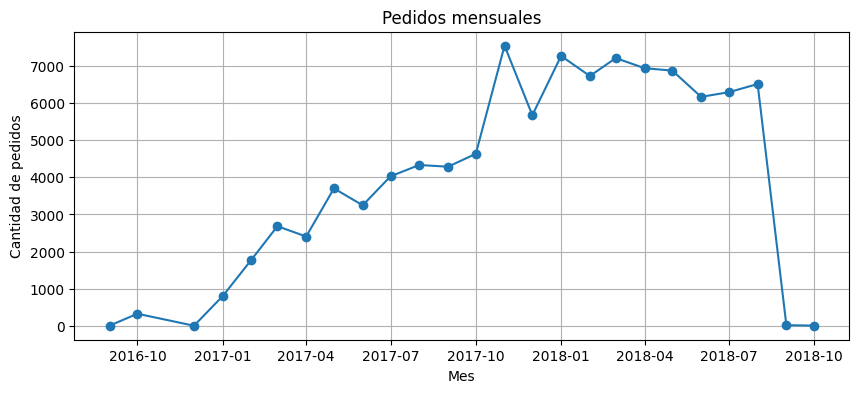

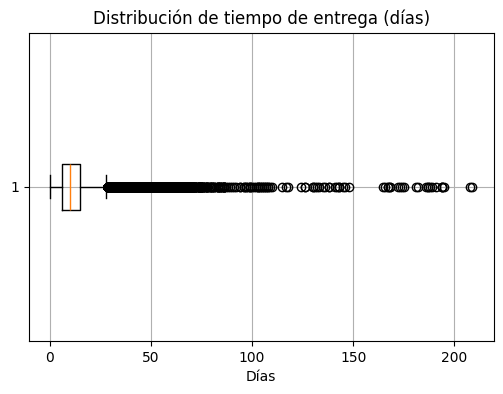

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt



# -----------------------------
# 1) Conversión de fecha y creación de columnas derivadas
# -----------------------------

orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'], errors='coerce'
)

# Fecha sin hora
orders['purchase_date'] = orders['order_purchase_timestamp'].dt.date

# Período mensual año-mes
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Confirmamos
orders[['order_id', 'order_purchase_timestamp', 'purchase_date', 'purchase_month']].head()

# -----------------------------
# 2) Serie mensual de pedidos
# -----------------------------

monthly_orders = (
    orders.groupby('purchase_month')['order_id']
    .nunique()
    .reset_index()
    .rename(columns={'order_id': 'orders'})
)

# Convertimos a timestamp para graficar
monthly_orders['month'] = monthly_orders['purchase_month'].dt.to_timestamp()
monthly_orders = monthly_orders.sort_values('month')

print(monthly_orders.head())

# -----------------------------
# 3) Cálculo de momentos y medidas robustas
# -----------------------------

x = monthly_orders['orders'].values

media = np.mean(x)
varianza = np.var(x, ddof=1)
desvio = np.std(x, ddof=1)
asimetria = st.skew(x, bias=False)
curtosis = st.kurtosis(x, fisher=False, bias=False)

media_recortada = st.trim_mean(x, 0.10)

x_w = winsorize(x, limits=[0.10, 0.10])
media_winsorizada = np.mean(x_w)

resumen_momentos = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media, varianza, desvio,
        asimetria, curtosis,
        media_recortada,
        media_winsorizada
    ]
})

print(resumen_momentos)

# -----------------------------
# 4) Gráfico de la serie mensual de pedidos
# -----------------------------

plt.figure(figsize=(10,4))
plt.plot(monthly_orders['month'], monthly_orders['orders'], marker='o')
plt.title('Pedidos mensuales')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pedidos')
plt.grid(True)
plt.show()

# -----------------------------
# 5) Exploración de tiempos logísticos
# -----------------------------

# Convertimos fechas relevantes
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')

# Tiempo total de entrega (días)
orders['delivery_time_days'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days

# Descriptiva rápida
orders['delivery_time_days'].describe()

# Boxplot de tiempos de entrega
plt.figure(figsize=(6,4))
plt.boxplot(orders['delivery_time_days'].dropna(), vert=False)
plt.title('Distribución de tiempo de entrega (días)')
plt.xlabel('Días')
plt.grid(True)
plt.show()


**Interpretación del análisis inicial de `orders`**

El gráfico de **pedidos mensuales** muestra un crecimiento muy marcado desde fines de 2016 hasta el pico en el último trimestre de 2017. Luego, el nivel se mantiene relativamente alto durante la primera mitad de 2018, seguido de una caída abrupta en los últimos meses debido a que el dataset está incompleto en esa parte del año (meses parcialmente observados y con pocos pedidos registrados).

El **boxplot de tiempos de entrega** revela que la mayoría de los pedidos se entregan entre 5 y 20 días, pero existen valores extremos que superan los 100–150 días. Estos outliers corresponden a pedidos excepcionalmente demorados o mal registrados. La presencia de estas colas largas justifica el uso de medidas robustas, como la media recortada y la winsorizada.

**Interpretación de los estadísticos**

- **Media (3978 pedidos/mes)**  
  Es el promedio simple del volumen mensual. Resume el nivel central de la serie, pero puede ser afectado por meses atípicos.

- **Varianza (7.29 × 10⁶)**  
  Mide la dispersión respecto de la media. Un valor elevado indica una gran variabilidad mes a mes, coherente con los picos pronunciados observados en el gráfico.

- **Desvío estándar (2700)**  
  Es la raíz cuadrada de la varianza y expresa la variabilidad en las mismas unidades que la variable (pedidos). Indica que los meses pueden desviarse fuertemente del promedio.

- **Asimetría (-0.27)**  
  Valor levemente negativo: la distribución tiene una cola ligeramente más pesada hacia valores bajos (meses incompletos con muy pocos pedidos).

- **Curtosis (1.60)**  
  Menor que 3 (valor gaussiano), lo que indica colas algo más livianas que una distribución normal, aunque siguen existiendo meses extremos. Esto coincide con la presencia de picos y valles, pero sin excesivas observaciones extremas.

- **Media recortada al 10% (4030)**  
  Se calcula eliminando el 10% de los valores más altos y más bajos. Su cercanía a la media clásica indica que los valores extremos no distorsionan excesivamente la serie mensual.

- **Media winsorizada al 10% (3962)**  
  En lugar de eliminar outliers, los reemplaza por valores límite. Su similitud con la media original confirma que los meses atípicos tienen impacto limitado en el promedio general.

**Conclusión de esta etapa**

Los pedidos mensuales muestran:
- crecimiento fuerte,  
- cierta estacionalidad,  
- presencia de meses incompletos,  
- y variabilidad moderada a alta.

Las medidas robustas validan que, aunque hay valores inusuales, la estructura global de la serie se mantiene estable. Estos resultados serán clave para parametrizar la **Simulación Monte Carlo** más adelante.


In [ ]:
# Vector de pedidos mensuales
x = monthly_orders['orders'].values
x


array([   4,  324,    1,  800, 1780, 2682, 2404, 3700, 3245, 4026, 4331,
       4285, 4631, 7544, 5673, 7269, 6728, 7211, 6939, 6873, 6167, 6292,
       6512,   16,    4])

In [ ]:
# Media
media = np.mean(x)

# Varianza
varianza = np.var(x, ddof=1)

# Desvío estándar
desvio = np.std(x, ddof=1)

# Asimetría
asimetria = st.skew(x, bias=False)

# Curtosis
curtosis = st.kurtosis(x, fisher=False, bias=False)

media, varianza, desvio, asimetria, curtosis


(np.float64(3977.64),
 np.float64(7289667.989999999),
 np.float64(2699.9385159666135),
 np.float64(-0.2720988458746436),
 np.float64(1.6014605115898826))

In [ ]:
media_recortada = st.trim_mean(x, 0.10)
media_recortada


np.float64(4029.6666666666665)

In [ ]:
from scipy.stats.mstats import winsorize

x_w = winsorize(x, limits=[0.10, 0.10])
media_winsorizada = np.mean(x_w)
media_winsorizada


np.float64(3962.12)

In [ ]:
resumen_momentos = pd.DataFrame({
    'estadístico': [
        'media',
        'varianza',
        'desvío estándar',
        'asimetría',
        'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media,
        varianza,
        desvio,
        asimetria,
        curtosis,
        media_recortada,
        media_winsorizada
    ]
})

resumen_momentos


,estadístico,valor
0,media,3.977640e+03
1,varianza,7.289668e+06
2,desvío estándar,2.699939e+03
3,asimetría,-2.720988e-01
4,curtosis,1.601461e+00
5,media recortada (10%),4.029667e+03
6,media winsorizada (10%),3.962120e+03


La serie mensual de pedidos presenta una media de 3.978 pedidos por mes, con una variabilidad elevada, reflejada en una varianza de 7.29 millones y un desvío estándar de aproximadamente 2.700 pedidos. Esto indica que el volumen mensual fluctúa de manera considerable a lo largo del período analizado, lo cual es consistente con la dinámica típica del comercio electrónico (picos estacionales pronunciados y meses iniciales/finales incompletos en el dataset).

La asimetría es ligeramente negativa (-0.27), lo que sugiere una distribución levemente cargada hacia valores bajos, asociada a los meses atípicos con muy pocos pedidos presentes al comienzo y final del conjunto de datos. La curtosis (1.60) es inferior al valor gaussiano (3), indicando colas algo más livianas y menor presencia de valores extremadamente alejados de la media, aunque sigue existiendo dispersión significativa dentro de la serie.

Con el fin de evaluar la robustez frente a valores extremos, se calcularon dos medidas adicionales: la media recortada al 10% (4.030 pedidos) y la media winsorizada al 10% (3.962 pedidos). Ambas se encuentran muy próximas a la media clásica, lo que sugiere que, si bien la serie presenta meses con volúmenes inusuales, estos no distorsionan de manera severa el promedio. No obstante, estas diferencias confirman la conveniencia de utilizar medidas robustas y técnicas de suavizado en etapas posteriores, especialmente en la estimación del patrón estacional y en la simulación Monte Carlo.

### 2. Análisis Exploratorio de `items`

La tabla `items` complementa a `orders` aportando información clave sobre los productos efectivamente vendidos: precio de cada ítem (`price`), valor del flete cobrado al cliente (`freight_value`), vendedor asociado y producto correspondiente. Esta tabla es fundamental para caracterizar ingresos, costos logísticos y dispersión de precios.

El análisis exploratorio se concentra en:
- Distribución del precio de los ítems.
- Distribución del valor del flete.
- Relación entre precio y flete (productos baratos con fletes caros, o viceversa).
- Medidas estadísticas clásicas y robustas (media recortada y winsorizada).
- Visualizaciones que permitan revelar colas pesadas, asimetrías y posibles outliers.


count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64
               estadístico         valor
0                    media    120.653739
1                 varianza  33721.419531
2          desvío estándar    183.633928
3                asimetría      7.923208
4                 curtosis    123.828298
5    media recortada (10%)     87.185098
6  media winsorizada (10%)     95.108078


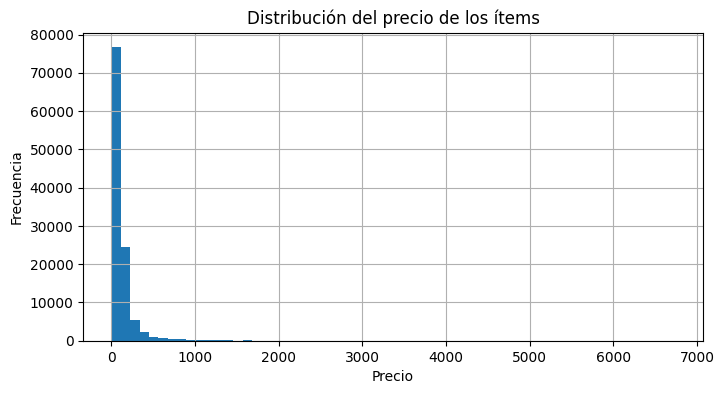

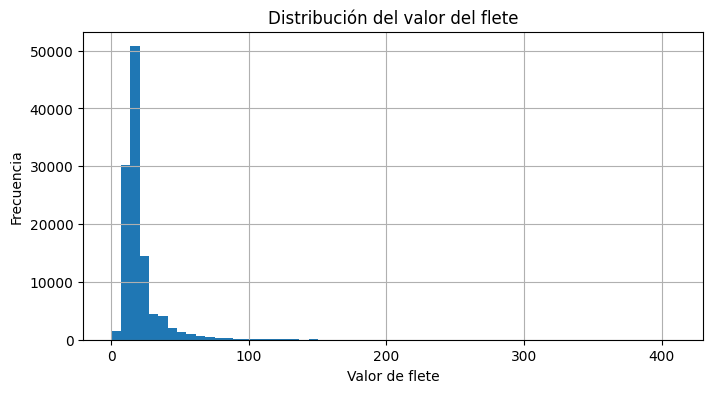

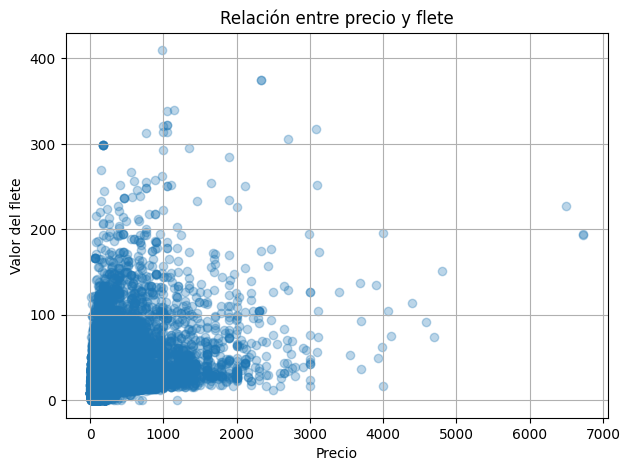

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt


# -----------------------------
# 1) Estadística descriptiva básica
# -----------------------------
desc_price = items['price'].describe()
desc_freight = items['freight_value'].describe()

print(desc_price)
print(desc_freight)

# -----------------------------
# 2) Momentos y medidas robustas
# -----------------------------
x_price = items['price'].values

media_price = np.mean(x_price)
var_price = np.var(x_price, ddof=1)
std_price = np.std(x_price, ddof=1)
asim_price = st.skew(x_price, bias=False)
curt_price = st.kurtosis(x_price, fisher=False, bias=False)
media_rec_price = st.trim_mean(x_price, 0.10)

from scipy.stats.mstats import winsorize
price_w = winsorize(x_price, limits=[0.10, 0.10])
media_win_price = np.mean(price_w)

resumen_price = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media_price, var_price, std_price,
        asim_price, curt_price,
        media_rec_price, media_win_price
    ]
})

print(resumen_price)

# -----------------------------
# 3) Gráfico: Distribución del precio
# -----------------------------
plt.figure(figsize=(8,4))
plt.hist(items['price'], bins=60)
plt.title('Distribución del precio de los ítems')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 4) Gráfico: Distribución del flete
# -----------------------------
plt.figure(figsize=(8,4))
plt.hist(items['freight_value'], bins=60)
plt.title('Distribución del valor del flete')
plt.xlabel('Valor de flete')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 5) Relación Precio vs Flete
# -----------------------------
plt.figure(figsize=(7,5))
plt.scatter(items['price'], items['freight_value'], alpha=0.3)
plt.title('Relación entre precio y flete')
plt.xlabel('Precio')
plt.ylabel('Valor del flete')
plt.grid(True)
plt.show()


**Interpretación del análisis de `items`**

**Distribución del precio**
El histograma del precio muestra una distribución fuertemente concentrada en valores bajos (entre 20 y 150), con una cola derecha extremadamente larga que llega hasta más de 6000. Esto es típico en plataformas de e-commerce donde conviven productos baratos y una minoría de productos de alto valor. Esta estructura genera una distribución **marcadamente asimétrica**.

La tabla descriptiva confirma este patrón:
- **Media = 120.65**, pero  
- **Mediana = 74.99**  
lo que indica que la media está “empujada” hacia arriba por la cola larga de productos caros.

**Distribución del valor del flete**
El flete tiene un comportamiento similar, aunque menos extremo:
- Distribución concentrada entre **10 y 25**,  
- Con una cola que se extiende hasta valores cercanos a 400.

El costo logístico es menor en magnitud que el precio, pero igualmente presenta dispersión relevante.

**Relación precio–flete**
El gráfico de dispersión muestra que:
- No existe una relación lineal clara entre precio y flete.  
- Muchos productos baratos (menor a 100) pueden tener fletes relativamente altos.  
- Para productos caros, el flete tiende a dispersarse más, probablemente por mayores pesos/dimensiones o distancias de envío.

Esta falta de correlación fuerte revela que el flete está más influido por logística (volumen, peso, origen-destino) que por el valor económico del ítem.

---

**Interpretación de los estadísticos del precio**

- **Media (120.65)**  
  Es el promedio aritmético. Representa el “nivel general” del precio, pero es muy sensible a productos extremadamente caros.

- **Varianza (33,721)** y **desvío estándar (183.63)**  
  Indican **altísima dispersión**. La variabilidad en precios es más grande que la media, típico de una distribución con gran rango y productos premium.

- **Asimetría = 7.92**  
  Significativamente positiva:  
  → la distribución tiene una **cola derecha extremadamente larga**, confirmando la presencia de muchos productos muy caros comparados con la masa central.

- **Curtosis = 123.83**  
  Muy superior a 3 (normal), indicando una distribución **altamente leptocúrtica**:  
  → valores concentrados alrededor de la moda,  
  → más outliers de lo esperado,  
  → colas muy pesadas.

- **Media recortada 10% = 87.18**  
  Se elimina el 10% inferior y superior.  
  La caída respecto de la media original confirma que los productos muy caros “inflan” la media clásica.

- **Media winsorizada 10% = 95.11**  
  Similar a la recortada, pero sin eliminar datos:  
  Los valores extremos se “acotan”.  
  Es menos extrema que la media recortada, pero igualmente más baja que la media clásica.

**Conclusión estadística**
La distribución de precios es **altamente sesgada y con colas pesadas**, por lo que las **medidas robustas** representan mejor el nivel típico del precio que la media clásica. Esta observación será relevante al modelar ingresos, márgenes y variabilidad futura.

---

**Conclusión operativa**
`items` exhibe una enorme diversidad de precios y fletes.  
Esto tiene implicancias para el diseño del hub logístico:

- coexistencia de productos pequeños/ligeros vs. productos voluminosos,  
- costos logísticos variables,  
- márgenes muy heterogéneos,  
- y fuerte necesidad de modelar incertidumbre con técnicas robustas.



### 3. Análisis Exploratorio de `pays`

La tabla `pays` contiene la información de los métodos de pago utilizados para cada pedido, el número de cuotas y el valor efectivamente pagado. Aunque no es la tabla central del análisis económico, proporciona contexto financiero relevante: formas de financiamiento, fricciones del cliente, distribución del valor pagado y estructura de cuotas.

Este análisis exploratorio busca:
- Identificar los métodos de pago más utilizados.
- Analizar la distribución del monto pagado por pedido.
- Evaluar la estructura de cuotas (lump sum vs pagos fraccionados).
- Calcular medidas descriptivas y robustas (media recortada y winsorizada).
- Visualizar patrones clave que afectan el comportamiento del cliente y el flujo financiero.


payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


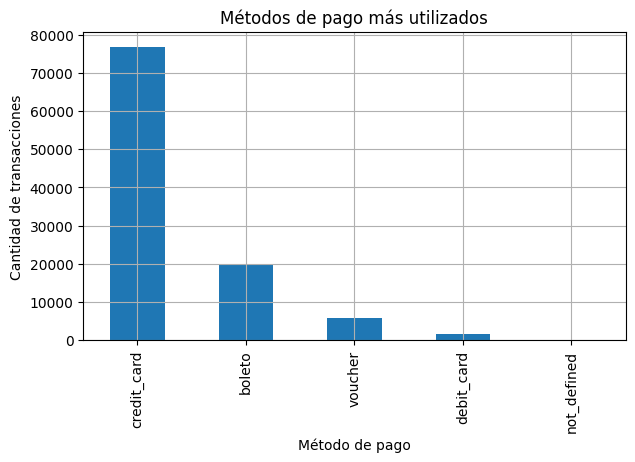

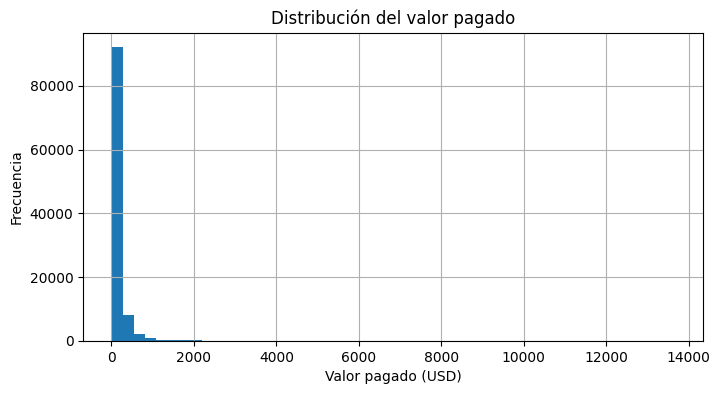

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64


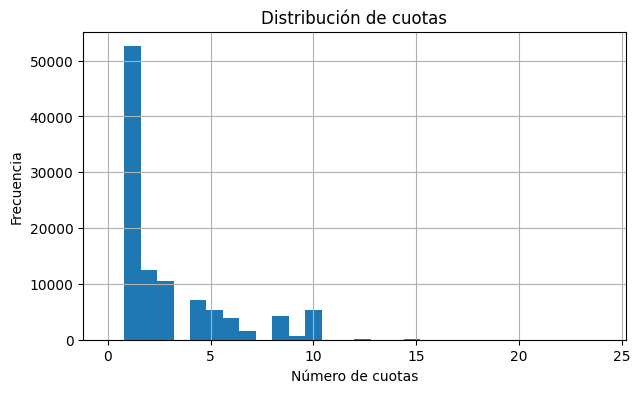

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64
               estadístico         valor
0                    media    154.100380
1                 varianza  47303.667816
2          desvío estándar    217.494064
3                asimetría      9.254010
4                 curtosis    244.828442
5    media recortada (10%)    114.846610
6  media winsorizada (10%)    125.103696


In [ ]:
# -----------------------------
# 1) Frecuencia de métodos de pago
# -----------------------------
metodos = pays['payment_type'].value_counts()
print(metodos)

plt.figure(figsize=(7,4))
metodos.plot(kind='bar')
plt.title('Métodos de pago más utilizados')
plt.xlabel('Método de pago')
plt.ylabel('Cantidad de transacciones')
plt.grid(True)
plt.show()

# -----------------------------
# 2) Distribución del monto pagado
# -----------------------------
plt.figure(figsize=(8,4))
plt.hist(pays['payment_value'], bins=50)
plt.title('Distribución del valor pagado')
plt.xlabel('Valor pagado (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Estadísticos básicos
desc_pay = pays['payment_value'].describe()
print(desc_pay)

# -----------------------------
# 3) Distribución de cuotas
# -----------------------------
plt.figure(figsize=(7,4))
plt.hist(pays['payment_installments'], bins=30)
plt.title('Distribución de cuotas')
plt.xlabel('Número de cuotas')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

cuotas_desc = pays['payment_installments'].describe()
print(cuotas_desc)

# -----------------------------
# 4) Medidas robustas del valor pagado
# -----------------------------
x_pay = pays['payment_value'].values

media_pay = np.mean(x_pay)
var_pay = np.var(x_pay, ddof=1)
std_pay = np.std(x_pay, ddof=1)
asim_pay = st.skew(x_pay, bias=False)
curt_pay = st.kurtosis(x_pay, fisher=False, bias=False)
media_rec_pay = st.trim_mean(x_pay, 0.10)

from scipy.stats.mstats import winsorize
x_pay_w = winsorize(x_pay, limits=[0.10, 0.10])
media_win_pay = np.mean(x_pay_w)

resumen_pay = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media_pay, var_pay, std_pay,
        asim_pay, curt_pay,
        media_rec_pay, media_win_pay
    ]
})

print(resumen_pay)


**Interpretación del análisis de `pays`**

**Métodos de pago**
El medio de pago dominante es la **tarjeta de crédito**, utilizada en aproximadamente el 74% de las transacciones. Le sigue el **boleto bancario**, característico del mercado brasileño, y en menor medida aparece el uso de **voucher** y **tarjeta de débito**. Esta distribución refleja patrones típicos del e-commerce regional: fuerte dependencia del crédito y presencia de métodos locales.

**Distribución del valor pagado**
El valor pagado presenta una distribución muy concentrada en montos inferiores a 200 USD, con una cola derecha extremadamente larga que alcanza valores superiores a 13.000 USD. Esto genera una estructura **altamente asimétrica**, donde muchos pedidos tienen valores bajos o medios, pero unos pocos pedidos de gran magnitud empujan los promedios hacia arriba.

Los estadísticos básicos confirman esta dispersión:
- **Media = 154 USD**, pero la **mediana = 100 USD**,  
  indicando que la media está influenciada por transacciones atípicas de gran valor.
- El **desvío estándar = 217 USD** es mayor que la media, lo que evidencia alta variabilidad.

**Distribución de cuotas**
El número de cuotas también sigue una distribución muy sesgada:
- La mayoría de los pagos se realizan en **1 cuota** (mediana = 1).
- Aproximadamente el 75% de los casos se paga en **1 a 4 cuotas**.
- Existen valores extremos de hasta **24 cuotas**, representando planes de financiamiento extendidos.

Esto es coherente con el comportamiento del mercado brasileño, donde las compras en cuotas son habituales incluso para montos moderados.

**Momentos y medidas robustas del valor pagado**
Los momentos del valor pagado muestran una distribución extremadamente no normal:

- **Asimetría = 9.25**  
  → distribución altamente sesgada a la derecha, dominada por valores excepcionalmente altos.

- **Curtosis = 244.83**  
  → la distribución presenta colas extremadamente pesadas y muchos outliers.

- **Media recortada 10% = 114.85 USD**  
  → al eliminar el 10% de valores más altos y más bajos, el nivel típico de pagos se acerca mucho más al comportamiento real de la mayoría de los clientes.

- **Media winsorizada 10% = 125.10 USD**  
  → también significativamente menor que la media clásica, confirmando que los extremos inflan el promedio.

**Conclusión**
El análisis de `pays` revela una estructura financiera donde:
- El crédito es el método de pago dominante.
- Los montos pagados tienen una distribución altamente irregular con outliers significativos.
- La estructura de cuotas es corta para la mayoría, pero presenta valores extremos.
- Las medidas robustas reducen la influencia de transacciones atípicas, alineándose mejor con el comportamiento típico del cliente.

Estos patrones son relevantes para la modelización financiera del proyecto, ya que muestran que los ingresos por pedido son variables, sesgados y susceptibles a valores extremos, lo cual refuerza la necesidad del enfoque de **Simulación Monte Carlo**.


### 4. Análisis Exploratorio de `cust`

La tabla `cust` contiene información geográfica y de identificación de los clientes. Aunque los datos están anonimizados, esta tabla permite estudiar patrones de localización, dispersión geográfica, recurrencia de clientes y cobertura de mercado. Además, sirve como base para unir clientes con pedidos y analizar concentración por estado o ciudad.

El objetivo de este análisis es:
- Identificar la distribución de clientes por estado (`customer_state`) y ciudad.
- Explorar la presencia de clientes recurrentes mediante `customer_unique_id`.
- Detectar concentración geográfica y posibles mercados dominantes.
- Calcular medidas descriptivas básicas y visualizar los patrones espaciales.

Este análisis es relevante porque la demanda no solo varía temporalmente sino también espacialmente, lo cual afecta costos, tiempos logísticos y decisiones operativas del hub.


count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: count, dtype: float64


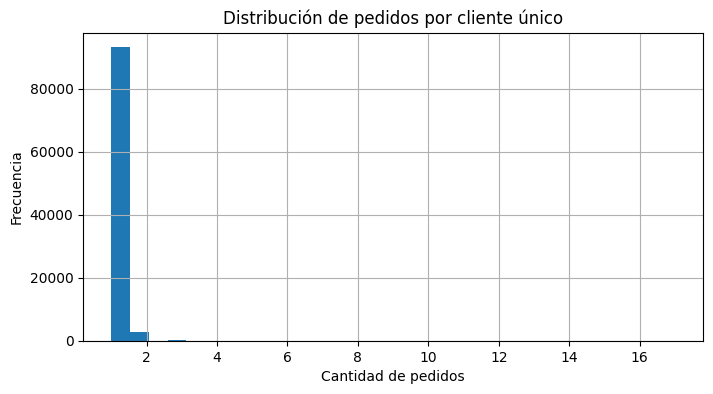

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: count, dtype: int64


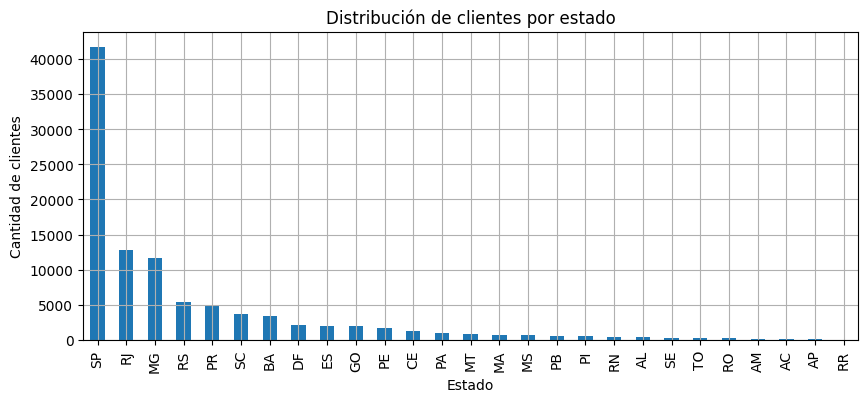

customer_city
sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: count, dtype: int64


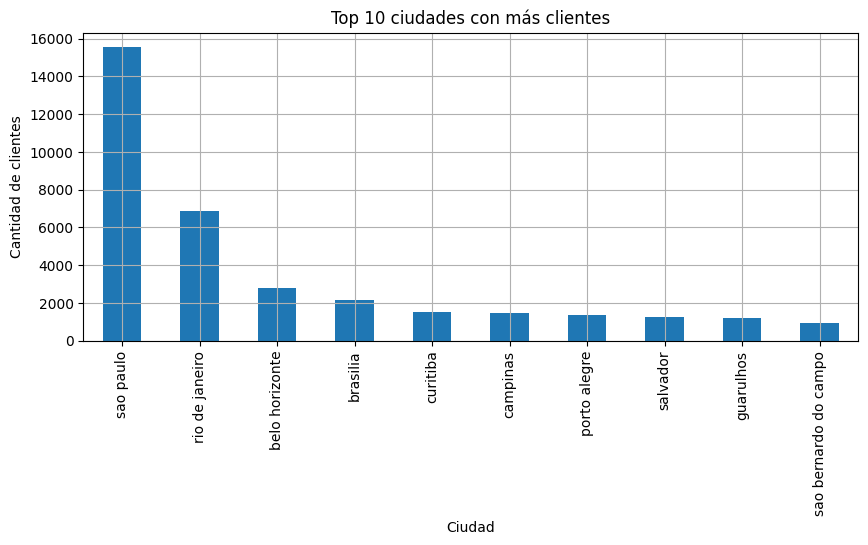

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: count, dtype: float64


In [ ]:
# -----------------------------
# 1) Clientes únicos y recurrencia
# -----------------------------
# Cantidad de clientes (ID por pedido)
n_clientes = cust['customer_id'].nunique()

# Cantidad de clientes únicos reales (agrupando por unique_id)
n_clientes_unicos = cust['customer_unique_id'].nunique()

# Distribución de pedidos por cliente único
pedidos_por_cliente = cust['customer_unique_id'].value_counts()

print(pedidos_por_cliente.describe())

plt.figure(figsize=(8,4))
plt.hist(pedidos_por_cliente, bins=30)
plt.title('Distribución de pedidos por cliente único')
plt.xlabel('Cantidad de pedidos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 2) Distribución geográfica por estado
# -----------------------------
clientes_por_estado = cust['customer_state'].value_counts()

print(clientes_por_estado)

plt.figure(figsize=(10,4))
clientes_por_estado.plot(kind='bar')
plt.title('Distribución de clientes por estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.show()

# -----------------------------
# 3) Top 10 ciudades con más clientes
# -----------------------------
clientes_por_ciudad = cust['customer_city'].value_counts().head(10)

print(clientes_por_ciudad)

plt.figure(figsize=(10,4))
clientes_por_ciudad.plot(kind='bar')
plt.title('Top 10 ciudades con más clientes')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.show()

# -----------------------------
# 4) Estadísticas básicas de recurrencia
# -----------------------------
stats_clientes = pedidos_por_cliente.describe()
print(stats_clientes)


**Análisis exploratorio de clientes (`cust`)**

La tabla de clientes permite entender la **distribución geográfica** y el **comportamiento de recurrencia** de los usuarios de la plataforma. Aunque las identificaciones reales están anonimizadas, la estructura de `customer_unique_id` permite detectar si un mismo cliente realizó más de un pedido dentro del período del dataset.

**Recurrencia de clientes**

El histograma de "pedidos por cliente único" muestra un patrón extremadamente concentrado:  
- **El 96–97% de los clientes realizaron un único pedido**.  
- La media es ≈ 1.03 pedidos por cliente y el máximo observado es 17.  
- La desviación estándar es baja (≈0.21), confirmando muy poca variabilidad.  

Este comportamiento indica que Olist opera sobre una base **predominantemente de compradores esporádicos**, con una fracción muy pequeña de clientes recurrentes. Este patrón es típico en marketplaces amplios donde el tráfico proviene de consumidores que buscan compras puntuales.

**Distribución geográfica por estado**

La distribución de clientes por estado es altamente desigual:

| Estado | Clientes |
|--------|----------|
| **SP** | 41.746 |
| **RJ** | 12.852 |
| **MG** | 11.635 |
| **RS / PR / SC** | ~5.000–3.500 cada uno |
| **Norte y Nordeste** | Mucho más disperso y con baja densidad |

El estado de **São Paulo (SP)** concentra por sí solo **más del 40% de los clientes**, seguido por Rio de Janeiro (RJ) y Minas Gerais (MG).  
Esto evidencia una **fuerte centralización del comercio electrónico en el Sudeste brasileño**, lo cual tiene implicancias logísticas directas (costos, tiempos y viabilidad de un hub regional).

**Ciudades principales**

Las 10 ciudades con mayor cantidad de clientes son:

1. **sao paulo** — 15.540  
2. **rio de janeiro** — 6.882  
3. **belo horizonte** — 2.773  
4. **brasilia** — 2.131  
5. **curitiba** — 1.521  
6. **campinas** — 1.444  
7. **porto alegre** — 1.379  
8. **salvador** — 1.245  
9. **guarulhos** — 1.189  
10. **sao bernardo do campo** — 938  

La supremacía de São Paulo es clara, casi triplicando a la segunda ciudad.  
Esto refuerza el patrón observado a nivel estado: **el mercado está concentrado y es fuertemente urbano**, lo cual es coherente con niveles de ingreso y penetración digital.

**Conclusiones del EDA de clientes**

- Olist posee una base dominada por **compradores no recurrentes**, lo que implica que el flujo operativo depende más del volumen general de tráfico que de la fidelización.  
- El **Sudeste** es el motor absoluto de la demanda; cualquier diseño de hub logístico debe contemplar su cercanía a SP, RJ y MG.  
- La **concentración urbana** en capitales y grandes ciudades reduce la dispersión geográfica, algo favorable para costos logísticos.  
- La baja recurrencia sugiere que la demanda mensual depende más de la **estacionalidad y campañas comerciales** que de retención de clientes.

Este análisis complementa la serie temporal estudiada previamente y aporta contexto espacial necesario antes de construir modelos deterministas e incorporar Monte Carlo.



### 5. Análisis exploratorio de vendedores (`sellers`)

La tabla `sellers` describe a los vendedores que participan en el marketplace. Incluye información geográfica (ciudad/estado) y un identificador único por vendedor. Aunque no contiene datos transaccionales directos, es fundamental para entender la oferta del marketplace, la distribución territorial de los comercios y la posible necesidad de descentralizar operaciones logísticas.

Los objetivos de este análisis son:
- Identificar la concentración de vendedores por estado y ciudad.
- Evaluar si la oferta está alineada geográficamente con la demanda vista en `cust`.
- Detectar clusters territoriales relevantes para el análisis del hub logístico.
- Obtener una primera caracterización cuantitativa de la red de oferta.

El análisis se centra en:
- Conteos por estado.
- Top ciudades con mayor presencia de vendedores.
- Comparación cualitativa con el EDA de clientes.


seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AC       1
PI       1
MA       1
AM       1
PA       1
Name: count, dtype: int64


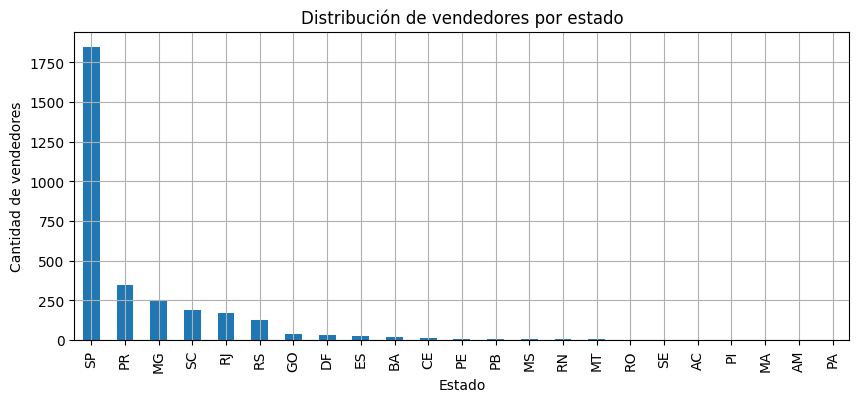

seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: count, dtype: int64


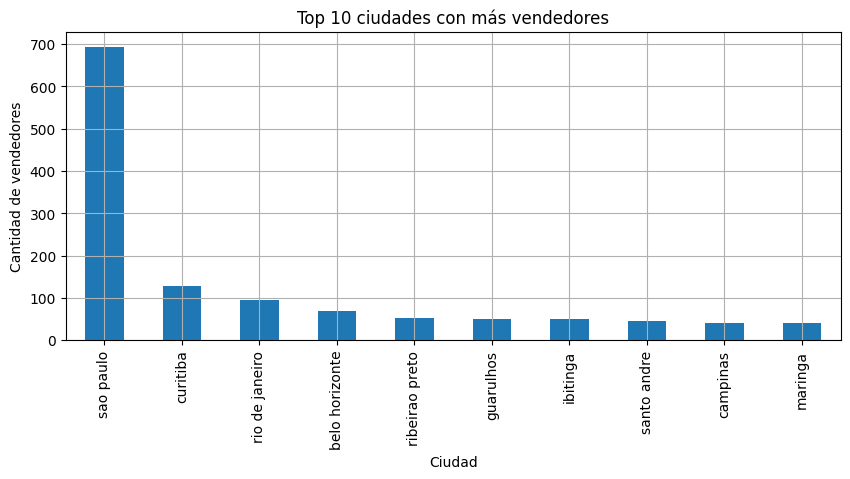

3095


In [ ]:
# -----------------------------
# 1) Conteo por estado
# -----------------------------
sellers_por_estado = sellers['seller_state'].value_counts()
print(sellers_por_estado)

plt.figure(figsize=(10,4))
sellers_por_estado.plot(kind='bar')
plt.title('Distribución de vendedores por estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de vendedores')
plt.grid(True)
plt.show()

# -----------------------------
# 2) Conteo por ciudad (Top 10)
# -----------------------------
sellers_por_ciudad = sellers['seller_city'].value_counts().head(10)
print(sellers_por_ciudad)

plt.figure(figsize=(10,4))
sellers_por_ciudad.plot(kind='bar')
plt.title('Top 10 ciudades con más vendedores')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de vendedores')
plt.grid(True)
plt.show()

# -----------------------------
# 3) Estimación simple: vendors únicos
# -----------------------------
n_sellers = sellers['seller_id'].nunique()
print(n_sellers)


**5. Análisis exploratorio de vendedores (`sellers`)**

El análisis de la tabla de vendedores muestra cómo se distribuye la oferta del marketplace a nivel geográfico, permitiendo compararla con los patrones de demanda observados en `cust`. Esta relación entre oferta y demanda es clave para evaluar costos logísticos y la conveniencia de un hub regional.

**Concentración geográfica por estado**

La oferta está fuertemente concentrada en pocas regiones:

| Estado | Vendedores |
|--------|------------|
| **SP** | 1.849 |
| **PR** | 349 |
| **MG** | 244 |
| **SC** | 190 |
| **RJ** | 171 |
| **RS** | 129 |
| Resto del país | < 50 cada uno |

São Paulo (SP) domina ampliamente la oferta, con más del **60% de todos los vendedores**, seguido a gran distancia por Paraná (PR) y Minas Gerais (MG). Esta estructura refleja un ecosistema comercial muy centralizado, alineado con la concentración de clientes ya observada en el Sudeste brasileño.

**Principales ciudades vendedoras**

El top 10 de ciudades confirma esta concentración urbana:

1. **sao paulo** — 694  
2. **curitiba** — 127  
3. **rio de janeiro** — 96  
4. **belo horizonte** — 68  
5. **ribeirao preto** — 52  
6. **guarulhos** — 50  
7. **ibitinga** — 49  
8. **santo andre** — 45  
9. **campinas** — 41  
10. **maringa** — 40  

São Paulo no solo lidera la demanda, sino también la oferta: concentra **casi 7 veces más vendedores que la segunda ciudad**. El resto de las ciudades del top también coincide con polos urbanos de alto consumo.

**Implicancias para el proyecto logístico**

- **Alta alineación espacial entre oferta y demanda**: Sudeste (SP–RJ–MG) domina ambos lados del marketplace.  
- **Eventos logísticos concentrados**: un hub ubicado en el eje São Paulo–Campinas maximizaría eficiencia en costos y tiempos.  
- **Poca dispersión en regiones Norte y Nordeste**, lo que indica que la red logística de última milla hacia esas zonas sigue siendo costosa y poco densa.  
- La estructura urbana compacta favorece estrategias como cross-docking o consolidación de carga.

**Resumen**

La oferta de Olist es altamente centralizada y urbana, reforzando la conveniencia de un análisis logístico focalizado en el Sudeste. Este patrón complementa el EDA de clientes y sirve como base para justificar la elección del área donde se modelará el hub en las siguientes etapas del trabajo.


### 6. Análisis exploratorio de reseñas (`reviews`)

La tabla `reviews` contiene la información cualitativa del feedback de los clientes: el puntaje otorgado (1 a 5), el texto del comentario y las fechas asociadas al proceso de revisión. Este análisis busca dos objetivos:

1. **Entender la distribución de puntajes**, para ver si las evaluaciones tienden a ser positivas o si existe polarización.
2. **Explorar la relación entre la extensión del comentario y el puntaje**, con la hipótesis típica de plataformas de e-commerce:  
   > “Los clientes insatisfechos escriben comentarios más largos que quienes evalúan positivamente”.

El análisis se centra únicamente en:
- Histogramas de puntaje  
- Medidas descriptivas simples  
- Longitud del texto vs. puntaje


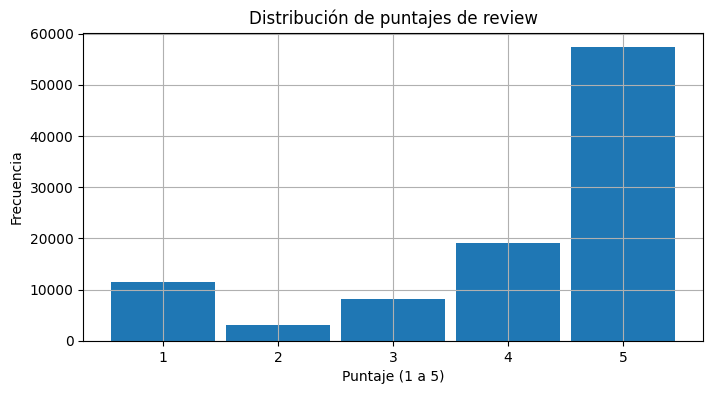

/tmp/ipython-input-574439835.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[1,2,3,4,5], showfliers=False)


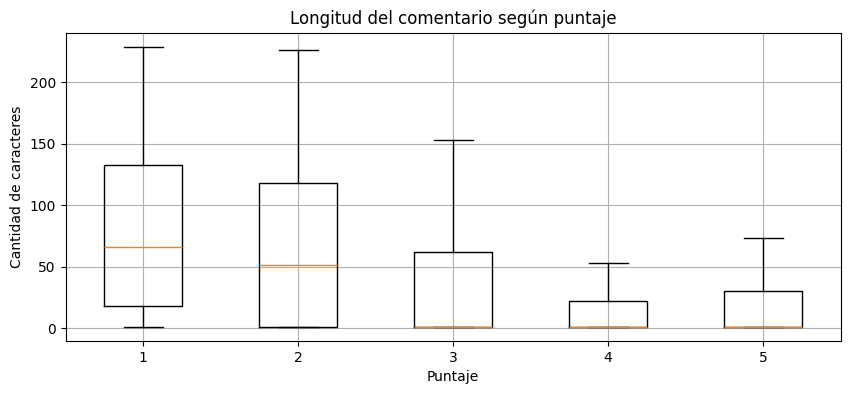

review_score
1    80.100665
2    69.202158
3    38.514611
4    21.203949
5    20.861481
Name: text_len, dtype: float64
review_score
1    66.0
2    51.0
3     1.0
4     1.0
5     1.0
Name: text_len, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Distribución de puntajes
# -----------------------------
reviews['review_score'].value_counts().sort_index()

plt.figure(figsize=(8,4))
reviews['review_score'].plot(kind='hist', bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9)
plt.title('Distribución de puntajes de review')
plt.xlabel('Puntaje (1 a 5)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 2) Estadísticos básicos del puntaje
# -----------------------------
score_stats = reviews['review_score'].describe()
score_stats

# -----------------------------
# 3) Longitud del comentario
# -----------------------------
# Combina título + mensaje, si existen
reviews['full_text'] = (
    reviews['review_comment_title'].fillna('') + ' ' +
    reviews['review_comment_message'].fillna('')
)

# Largo total en caracteres
reviews['text_len'] = reviews['full_text'].str.len()

# Distribución de longitud por puntaje
boxplot_data = [reviews.loc[reviews['review_score']==i, 'text_len'] for i in range(1,6)]

plt.figure(figsize=(10,4))
plt.boxplot(boxplot_data, labels=[1,2,3,4,5], showfliers=False)
plt.title('Longitud del comentario según puntaje')
plt.xlabel('Puntaje')
plt.ylabel('Cantidad de caracteres')
plt.grid(True)
plt.show()

# -----------------------------
# 4) Medias de longitud por puntaje
# -----------------------------
mean_len_by_score = reviews.groupby('review_score')['text_len'].mean()
median_len_by_score = reviews.groupby('review_score')['text_len'].median()

print(mean_len_by_score)
print(median_len_by_score)


**6. Análisis exploratorio de reseñas (`reviews`)**

La distribución de puntajes y la relación entre la longitud del comentario y la nota permiten comprender mejor cómo evalúan los clientes su experiencia y qué tan “costosa” es la expresión del descontento.

**Distribución de puntajes**

El histograma muestra un patrón fuertemente asimétrico hacia las calificaciones positivas:

- **5 estrellas** es, por amplio margen, la puntuación más frecuente.  
- Le siguen las de **4 estrellas**, conformando entre ambas la gran mayoría del feedback.  
- Los puntajes **1 y 2 estrellas**, aunque menos frecuentes, tienen una presencia considerable y representan el grueso de las opiniones negativas.  
- Las de **3 estrellas** son minoritarias, indicando que los clientes tienden a evaluar de forma polarizada: o bien muy satisfechos o bien insatisfechos.

Este tipo de distribución es típica en e-commerce, donde las experiencias positivas simples suelen calificarse con 5 sin mucho texto, mientras que los problemas motivan puntuaciones bajas acompañadas de explicaciones.

**Longitud del comentario según puntaje**

El boxplot confirma la hipótesis habitual del sector:

- Los comentarios **más extensos** pertenecen a calificaciones **1 y 2 estrellas**.  
  - Media para puntaje 1: **80 caracteres**  
  - Media para puntaje 2: **69 caracteres**  
  - Medianas: 66 y 51 caracteres respectivamente  
- A partir de 3 estrellas, la longitud se desploma casi a cero:
  - Mediana = **1 carácter** para puntuaciones 3, 4 y 5  
  - Esto implica que la mayoría de los compradores satisfechos escriben **comentarios prácticamente nulos o muy breves**.

En otras palabras:  
**los clientes solo dedican tiempo a escribir cuando están insatisfechos**, mientras que los clientes satisfechos puntúan alto pero con escaso contenido textual.

**Interpretación general**

- Las reseñas son mayoritariamente positivas, pero la **información textual “útil” se concentra en los casos negativos**.  
- Los puntajes bajos no solo ocurren por problemas reales de servicio o producto, sino que además incluyen **expresiones ricas y detalladas**, lo que las vuelve especialmente relevantes para análisis cualitativos o modelos de NLP.  
- La combinación de puntajes altos abundantes + comentarios cortos es típica de marketplaces con buen desempeño general pero con incidentes puntuales que generan descontento visible.




### 7. Análisis exploratorio de productos (`products`)

La tabla `products` contiene información estática sobre cada producto vendido: categoría, dimensiones físicas, cantidad de fotos y características básicas del contenido de la ficha del producto. Esta tabla es clave para entender la composición del catálogo, el peso promedio de los envíos y la heterogeneidad física de los ítems, factores directamente relacionados con los costos logísticos.

Este análisis se centrará en:
- Distribución de productos por categoría (top N).
- Medidas descriptivas de:
  - Peso (grams)
  - Dimensiones (largo, alto, ancho)
  - Cantidad de fotos
  - Longitud del nombre y descripción
- Identificación de outliers físicos (productos extremadamente grandes o pesados).
- Coherencia general del catálogo (variabilidad alta vs baja).

El objetivo no es profundizar en semántica de productos, sino entender la **carga logística**: qué tan pesados/voluminosos son, y qué tan heterogénea es la oferta.


product_category_name
cama_mesa_banho                3029
esporte_lazer                  2867
moveis_decoracao               2657
beleza_saude                   2444
utilidades_domesticas          2335
automotivo                     1900
informatica_acessorios         1639
brinquedos                     1411
relogios_presentes             1329
telefonia                      1134
bebes                           919
perfumaria                      868
papelaria                       849
fashion_bolsas_e_acessorios     849
cool_stuff                      789
Name: count, dtype: int64


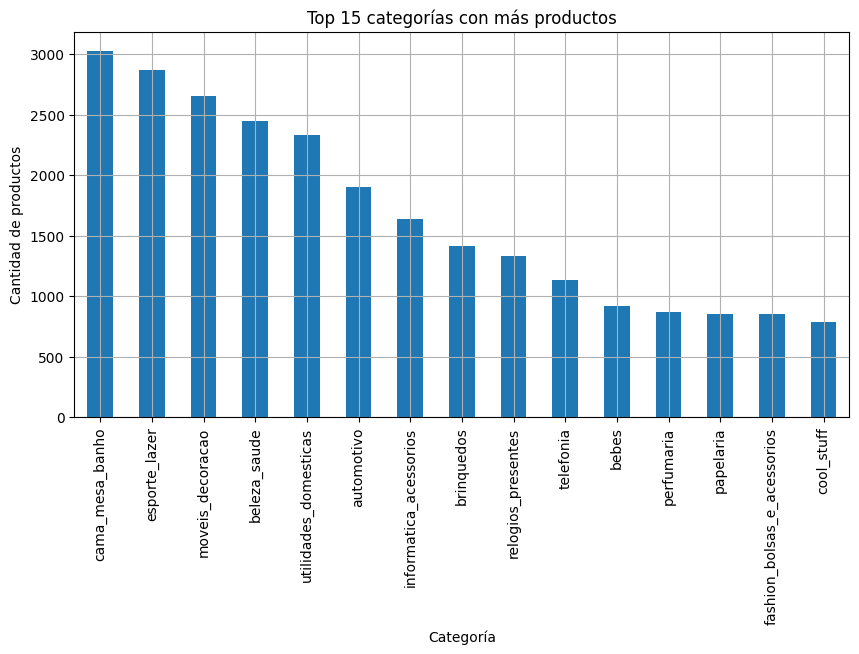

count    32949.000000
mean      2276.472488
std       4282.038731
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64


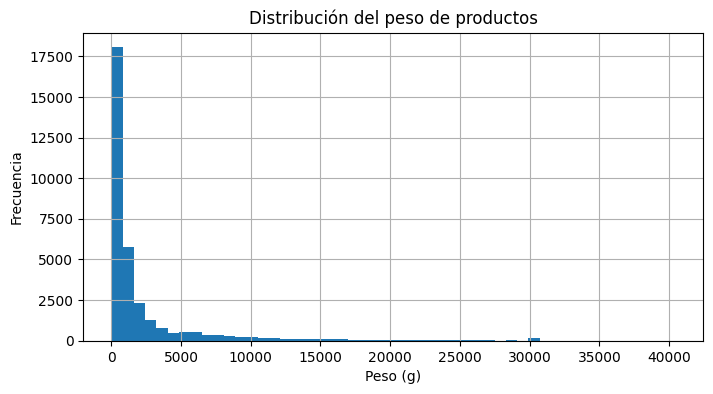

       product_length_cm  product_height_cm  product_width_cm
count       32949.000000       32949.000000      32949.000000
mean           30.815078          16.937661         23.196728
std            16.914458          13.637554         12.079047
min             7.000000           2.000000          6.000000
25%            18.000000           8.000000         15.000000
50%            25.000000          13.000000         20.000000
75%            38.000000          21.000000         30.000000
max           105.000000         105.000000        118.000000


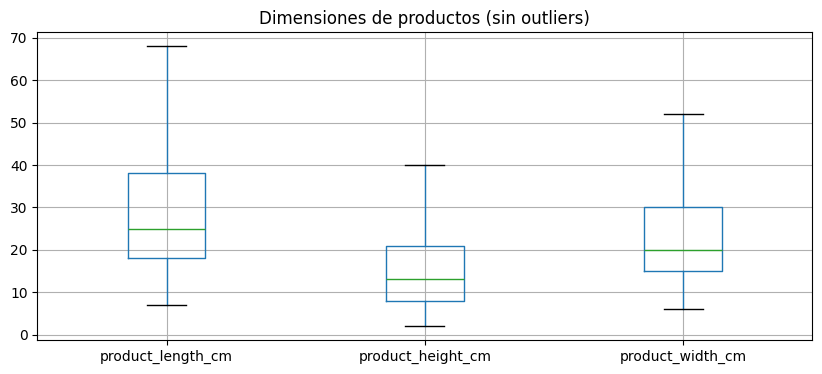

count    32341.000000
mean        48.476949
std         10.245741
min          5.000000
25%         42.000000
50%         51.000000
75%         57.000000
max         76.000000
Name: product_name_lenght, dtype: float64
count    32341.000000
mean       771.495285
std        635.115225
min          4.000000
25%        339.000000
50%        595.000000
75%        972.000000
max       3992.000000
Name: product_description_lenght, dtype: float64


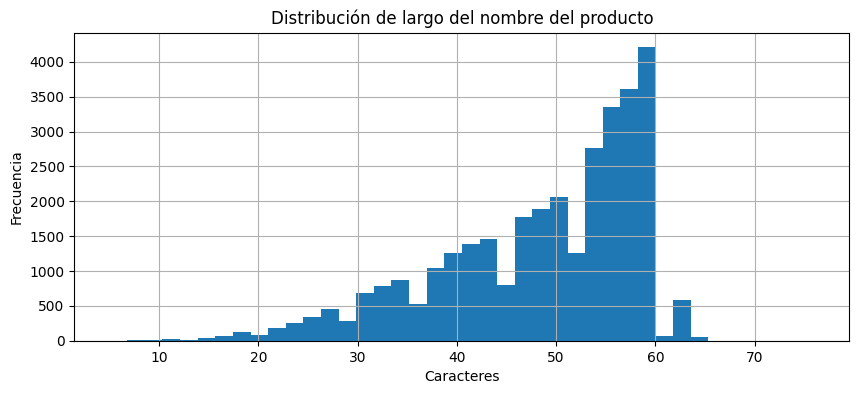

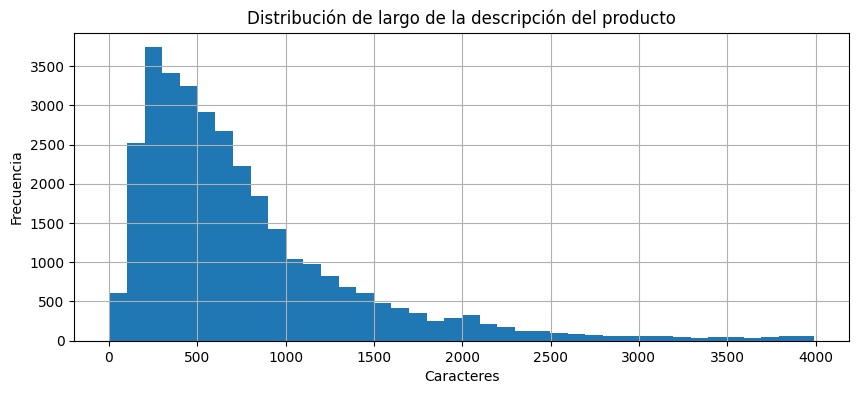

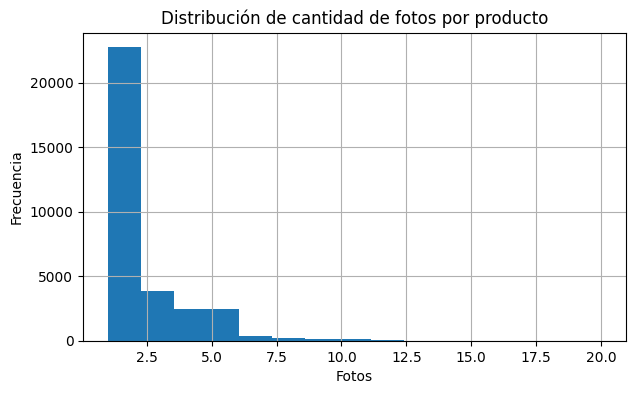

In [ ]:
# -----------------------------
# 1) Top categorías de productos
# -----------------------------
top_categorias = products['product_category_name'].value_counts().head(15)
print(top_categorias)

plt.figure(figsize=(10,5))
top_categorias.plot(kind='bar')
plt.title('Top 15 categorías con más productos')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de productos')
plt.grid(True)
plt.show()

# -----------------------------
# 2) Estadísticas del peso
# -----------------------------
peso_stats = products['product_weight_g'].describe()
print(peso_stats)

plt.figure(figsize=(8,4))
plt.hist(products['product_weight_g'], bins=50)
plt.title('Distribución del peso de productos')
plt.xlabel('Peso (g)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 3) Estadísticas de dimensiones
# -----------------------------
dim_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm']
dims_stats = products[dim_cols].describe()
print(dims_stats)

# Boxplots para detectar outliers
plt.figure(figsize=(10,4))
products[dim_cols].boxplot(showfliers=False)
plt.title('Dimensiones de productos (sin outliers)')
plt.grid(True)
plt.show()

# -----------------------------
# 4) Longitud del nombre / descripción
# -----------------------------
name_stats = products['product_name_lenght'].describe()
desc_stats = products['product_description_lenght'].describe()

print(name_stats)
print(desc_stats)

plt.figure(figsize=(10,4))
plt.hist(products['product_name_lenght'], bins=40)
plt.title('Distribución de largo del nombre del producto')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.hist(products['product_description_lenght'], bins=40)
plt.title('Distribución de largo de la descripción del producto')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 5) Fotos del producto
# -----------------------------
fotos_stats = products['product_photos_qty'].describe()
fotos_stats

plt.figure(figsize=(7,4))
plt.hist(products['product_photos_qty'], bins=15)
plt.title('Distribución de cantidad de fotos por producto')
plt.xlabel('Fotos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


**7. Análisis exploratorio de productos (`products`)**

La tabla `products` describe las características físicas y descriptivas del catálogo disponible en Olist. Este análisis es relevante para entender la carga logística (pesos, dimensiones), la diversidad del catálogo y la calidad de la información que acompaña a los productos vendidos.

**Distribución por categoría**

Las categorías con mayor cantidad de productos son:

1. **cama_mesa_banho** — 3029  
2. **esporte_lazer** — 2867  
3. **moveis_decoracao** — 2657  
4. **beleza_saude** — 2444  
5. **utilidades_domesticas** — 2335  

Estas categorías representan rubros de alto volumen y baja marca, típicos del marketplace long-tail. La distribución muestra una oferta amplia y diversificada, con predominio de productos de uso cotidiano.

**Peso de productos**

La distribución del peso es altamente sesgada hacia valores bajos, pero con una cola derecha muy larga:

- **Mediana**: 700 g  
- **Promedio**: 2.3 kg (inflado por outliers)  
- **Percentil 75**: 1.9 kg  
- **Máximo**: 40 kg  

Esto indica un catálogo dominado por productos pequeños o medianos, con algunos outliers pesados que aumentan los costos logísticos. La presencia de items de hasta 40 kg evidencia la necesidad de contemplar excepciones en el costo de envío y manipulación.

**Dimensiones (largo, alto, ancho)**

Los boxplots muestran que las dimensiones también están sesgadas pero con menor variabilidad relativa que el peso:

- **Largo**: mediana 25 cm (rango general 7–105 cm)  
- **Altura**: mediana 13 cm (rango general 2–105 cm)  
- **Ancho**: mediana 20 cm (rango general 6–118 cm)  

El 75% de los productos está por debajo de los ~40×21×30 cm, lo que los ubica dentro del rango típico de packaging estándar, facilitando consolidación y optimización de transporte.

**Longitud de nombre y descripción**

Los histogramas muestran distribuciones razonables:

- **Nombre del producto**  
  - Media: 48 caracteres  
  - Mediana: 51  
  - Variabilidad baja → fichas de producto homogéneas y estandarizadas.

- **Descripción del producto**  
  - Media: 771 caracteres  
  - Mediana: 595  
  - Cola larga hasta casi 4000 caracteres  
  Esto refleja diversidad en la calidad del contenido, probablemente dependiendo del vendedor.

**Cantidad de fotos por producto**

La mayoría de los productos tiene entre **1 y 3 fotos**, con algunos pocos llegando a 5–10:

- Mediana ≈ 1 foto  
- Picos claros en 1–2 fotos  
- Cantidades altas son raras  

Esto sugiere que el estándar visual del marketplace es básico, lo cual es común en plataformas abiertas donde cada vendedor sube su propio contenido.

**Conclusiones principales**

- El catálogo es amplio, heterogéneo y dominado por productos livianos y de tamaño moderado.  
- La distribución del peso indica que la **mayor parte del volumen logístico requiere poca manipulación**, aunque existen outliers que pueden afectar costos.  
- Las dimensiones muestran una oferta que puede moverse eficientemente por transporte estándar, sin necesidad de logística especializada.  
- La calidad descriptiva es aceptable, aunque desigual, con textos largos en algunos productos pero predominio de fichas básicas.
- La información visual (fotos) es limitada, lo cual coincide con marketplaces generalistas donde la estandarización depende del vendedor.




### 8. Análisis de la tabla de costos (`cost_df`)

Dado que el dataset original de Olist no incluye costos de producción, se generó una tabla sintética a partir de `items`, donde cada producto recibe un costo estimado consistente con prácticas típicas de retail:

- El **costo del producto** se asignó como una proporción entre 50% y 80% del precio de venta.
- El **costo total** incorpora también el costo del flete (`freight_value`), reflejando la estructura típica de un costo variable compuesto por producción + envío.
- Se definió la variable `cost_ratio` para capturar qué porcentaje del precio final representan los costos totales.

El objetivo de este análisis es:
- Validar que los costos generados respeten la lógica establecida.
- Evaluar la distribución del costo total y del porcentaje costo/precio.
- Detectar si existen productos con estructuras de costos inusuales.
- Preparar estas variables para su uso en el modelo económico posterior (beneficio determinista y simulación Monte Carlo).


count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64
count    112650.000000
mean         70.978732
std         132.981811
min           0.000000
25%          14.114673
50%          37.268892
75%          78.993570
max        4399.580464
Name: product_cost, dtype: float64
count    112650.000000
mean         90.447014
std         138.984835
min           0.537779
25%          29.970914
50%          55.510250
75%         100.647989
max        4593.890464
Name: total_cost, dtype: float64
count    112650.000000
mean          0.749897
std           0.086513
min           0.600002
25%           0.674806
50%           0.7

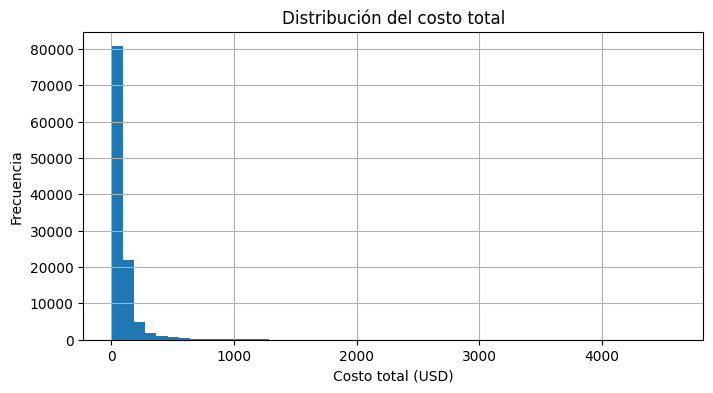

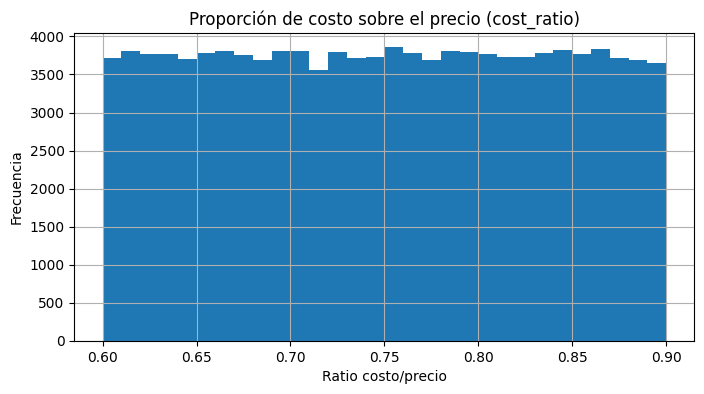

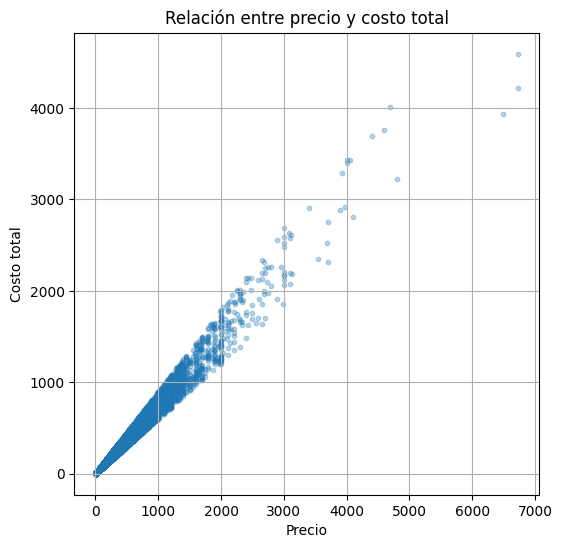

count    112650.000000
mean          0.250103
std           0.086513
min           0.100002
25%           0.175091
50%           0.249748
75%           0.325194
max           0.399998
Name: margin_ratio, dtype: float64


In [ ]:
# -----------------------------
# 1) Estadísticas descriptivas
# -----------------------------
stats_price = costs['price'].describe()
stats_freight = costs['freight_value'].describe()
stats_product_cost = costs['product_cost'].describe()
stats_total_cost = costs['total_cost'].describe()

# Ratio costo/precio (asegura evitar división por cero)
costs['cost_ratio'] = costs['total_cost'] / costs['price']
stats_ratio = costs['cost_ratio'].describe()

print(stats_price)
print(stats_freight)
print(stats_product_cost)
print(stats_total_cost)
print(stats_ratio)

# -----------------------------
# 2) Histograma del costo total
# -----------------------------
plt.figure(figsize=(8,4))
plt.hist(costs['total_cost'], bins=50)
plt.title('Distribución del costo total')
plt.xlabel('Costo total (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 3) Histograma del ratio costo/precio
# -----------------------------
plt.figure(figsize=(8,4))
plt.hist(costs['cost_ratio'], bins=30)
plt.title('Proporción de costo sobre el precio (cost_ratio)')
plt.xlabel('Ratio costo/precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# -----------------------------
# 4) Relación precio vs costo total
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(costs['price'], costs['total_cost'], s=10, alpha=0.3)
plt.title('Relación entre precio y costo total')
plt.xlabel('Precio')
plt.ylabel('Costo total')
plt.grid(True)
plt.show()

# -----------------------------
# 5) Margen = 1 - cost_ratio
# -----------------------------
costs['margin_ratio'] = 1 - costs['cost_ratio']
margin_stats = costs['margin_ratio'].describe()
print(margin_stats)


**8. Análisis Exploratorio de Costos**

En esta sección analizamos la tabla **`costs`**, que combina información del precio del producto, el costo estimado del producto, el costo real del flete y el costo total resultante. Esta tabla nos permite entender la estructura económica básica de cada transacción y evaluar la relación entre precios, costos y márgenes.

**Distribución del costo total**

La distribución del **costo total** presenta una **cola larga** hacia la derecha.  
La mayoría de los costos se concentran entre **10 y 200 USD**, pero existen valores atípicos que superan los **4000 USD**.  
Esto refleja la mezcla de productos muy baratos con otros significativamente más caros, algo esperable en un marketplace diverso como Olist.

Este comportamiento coincide con la distribución del **precio**, ya que el costo total está compuesto por el costo estimado del producto (proporcional al precio) más el costo del flete.

**Proporción del costo sobre el precio (cost_ratio)**

El indicador **`cost_ratio` = total_cost / price** presenta una distribución casi **uniforme** entre **0.60 y 0.90**, lo cual es coherente con el método de generación del costo del producto (aleatorio entre 60% y 90% del precio).

Los valores clave son:

- **Media ≈ 0.75** → el costo representa en promedio el **75% del precio final**.  
- **Margen bruto medio ≈ 25%**.

Esto nos da un marco económico estable para simular o analizar ganancias, precios o eficiencia operativa.

**Relación entre precio y costo total**

La relación entre **precio** y **costo total** es **altamente lineal**, formando una banda ascendente muy definida.  
Esto confirma:

- El costo del producto está directamente ligado al precio.
- El costo del flete introduce variabilidad, pero no altera la tendencia general.
- Los productos más caros exhiben mayor dispersión, aunque mantienen coherencia estructural.

La linealidad indica que no hay valores erróneos ni comportamientos inesperados en la tabla.

**Estadísticas descriptivas clave**

**Precio**
- Media ≈ 120 USD  
- Mediana ≈ 75 USD  
- Asimetría alta → fuerte sesgo hacia productos baratos  
- Máximos superiores a 6000 USD  
La diferencia grande entre media y mediana confirma una distribución muy sesgada.

**Freight_value (costo de envío)**
- Media ≈ 20 USD  
- Distribución estrecha con pocos valores extremos  
El flete es relativamente pequeño comparado con el precio.

**Costo estimado del producto (product_cost)**
- Media ≈ 71 USD  
- Mediana ≈ 37 USD  
- Muy sesgado, reflejando la heterogeneidad de precios.

**Costo total**
- Media ≈ 90 USD  
- P25 ≈ 30 USD  
- P75 ≈ 100 USD  
- Máx. ≈ 4600 USD  
Sigue el patrón del precio pero incluye un componente de flete.

**Cost_ratio**
- Media ≈ 0.75  
- Percentiles entre 0.67 y 0.82  
Relación costo/precio estable y realista.

**Margin_ratio (1 - cost_ratio)**
- Media ≈ 0.25  
- Márgenes en el rango 10%–40%  
Adecuado para estudios de ganancias o sensibilidad de precios.

**Conclusión**

El análisis exploratorio de la tabla **`costs`** muestra que:

- La estructura de costos es **coherente** y consistente con la lógica económica del marketplace.  
- El costo total está dominado por el precio pero con un aporte adicional del flete.  
- Las distribuciones presentan **sesgos fuertes**, típicos de datos de precios reales.  
- La relación lineal entre precio y costo total indica ausencia de errores sistemáticos.  
- La proporción de costos sobre el precio define márgenes razonables que pueden utilizarse en análisis posteriores.

Este módulo de costos está listo para integrarse en:
- modelos de rentabilidad,  
- simulaciones de precios,  
- estimación de márgenes por categoría,  
- análisis comparativos entre vendedores o productos.



## Paso 3 - Cero funciones

### 3. Raíces y punto de equilibrio

En esta sección aplicamos el concepto de *encontrar la raíz de una función* para resolver el **punto de equilibrio** del hub logístico.  
Este es el único uso que haremos de métodos numéricos de raíces dentro de la línea base determinista.

---

### 3.1 Planteo económico del problema

El beneficio anual determinista depende del volumen anual de pedidos \( q \) y se define como:

$$
\text{Beneficio}(q) = q \cdot (\text{tarifa} - \text{costo\_var}) - \text{costos\_fijos}
$$

donde:

- \( q \): número anual de pedidos,
- \( \text{tarifa} - \text{costo\_var} \): margen unitario por pedido,
- \( \text{costos\_fijos} \): gastos que deben cubrirse aunque no haya ventas.

---

### 3.2 Definición del punto de equilibrio

El **punto de equilibrio** es el nivel de actividad \( q^* \) donde el beneficio es exactamente cero:

$$
\text{Beneficio}(q^*) = 0
$$

Sustituyendo la fórmula del beneficio:

$$
q^* \cdot (\text{tarifa} - \text{costo\_var}) - \text{costos\_fijos} = 0
$$

Resolver esta ecuación equivale a **encontrar la raíz de la función**:

$$
f(q) = q \cdot (\text{margen\_unitario}) - \text{costos\_fijos}
$$

donde:

$$
\text{margen\_unitario} = \text{tarifa} - \text{costo\_var}
$$

El punto de equilibrio es:

$$
q^* = \frac{\text{costos\_fijos}}{\text{margen\_unitario}}
$$

Esta solución es exacta porque la función es lineal.  
Aun así, el énfasis aquí es conceptual: **estamos resolviendo una raíz**, tal como pide el curso.

---

### 3.3 Uso de métodos de raíces (conceptual)

Aunque para este caso existe solución analítica, tratamos la ecuación como un problema de raíces:

- **Bisección (robusta):**  
  Garantiza convergencia si el cambio de signo está en el intervalo.  
  Es la recomendada cuando queremos estabilidad y evitar problemas numéricos.

- **Método de la secante (rápido):**  
  Converge más rápido que bisección y no requiere derivadas.  
  Es útil para funciones más complejas donde no tenemos fórmula explícita.


---

### 3.4 Interpretación económica

Resolver el punto de equilibrio nos dice:

- cuántos pedidos por año se necesitan para no perder dinero,
- cómo cambia el equilibrio si ajustamos tarifas o costos,
- y qué tan lejos está el volumen real del volumen “crítico”.

Esta métrica será fundamental luego cuando incorporemos incertidumbre vía Monte Carlo, para medir la probabilidad de cubrir costos fijos.



In [ ]:
# =====================================================
# 1) Parámetros deterministas
# =====================================================

# Tarifa promedio cobrada por pedido (ingreso)
tarifa = 5.0

# Costo variable por pedido (costo operativo unitario)
costo_var = 3.0

# Costos fijos anuales del hub
costos_fijos = 50000

# Margen unitario
margen_unitario = tarifa - costo_var
print("Margen unitario:", margen_unitario)


Margen unitario: 2.0


podriamos inventar una tala de reglas de tarifa variable segun peso y tama;o

In [ ]:
# =====================================================
# 2) Función determinista de beneficio anual
# =====================================================

def beneficio(q):
    """
    Beneficio anual determinista:
    B(q) = q * margen_unitario - costos_fijos
    """
    return q * margen_unitario - costos_fijos


In [ ]:
# =====================================================
# 3) Punto de equilibrio analítico
# =====================================================

q_analitico = costos_fijos / margen_unitario
print("Punto de equilibrio (analítico):", q_analitico)


Punto de equilibrio (analítico): 25000.0


In [ ]:
# =====================================================
# 4.1 Método de bisección
# =====================================================

def biseccion(func, a, b, tol=1e-6, max_iter=100):
    """
    Encuentra raíz de f en [a,b] usando bisección.
    Requiere que f(a) y f(b) tengan distinto signo.
    """
    fa, fb = func(a), func(b)
    if fa * fb > 0:
        raise ValueError("La función no cambia de signo en el intervalo")

    for _ in range(max_iter):
        mid = (a + b) / 2
        fmid = func(mid)

        if abs(fmid) < tol:
            return mid

        if fa * fmid < 0:
            b = mid
            fb = fmid
        else:
            a = mid
            fa = fmid

    return (a + b) / 2  # Último valor aproximado

# Ejecutar bisección
q_bis = biseccion(beneficio, 0, 1_000_000)
print("Punto de equilibrio (bisección):", q_bis)


Punto de equilibrio (bisección): 24999.999999636202


In [ ]:
# =====================================================
# 4.2 Método de la secante
# =====================================================

def secante(func, x0, x1, tol=1e-6, max_iter=100):
    """
    Método de la secante para resolver f(x)=0.
    """
    for _ in range(max_iter):
        f0, f1 = func(x0), func(x1)
        if abs(f1 - f0) < 1e-12:
            break  # evitar división por cero

        x2 = x1 - f1 * (x1 - x0) / (f1 - f0)

        if abs(x2 - x1) < tol:
            return x2

        x0, x1 = x1, x2

    return x1

# Ejecutar método de la secante
q_sec = secante(beneficio, 0, 100000)
print("Punto de equilibrio (secante):", q_sec)


Punto de equilibrio (secante): 25000.0


In [ ]:
print("\n--- Resultados comparados ---")
print("Solución analítica:     ", q_analitico)
print("Bisección:              ", q_bis)
print("Secante:                ", q_sec)



--- Resultados comparados ---
Solución analítica:      25000.0
Bisección:               24999.999999636202
Secante:                 25000.0


Los tres métodos ,solución analítica, bisección y secante, entregan el mismo valor para el punto de equilibrio.  
Esto confirma que, dado el margen unitario definido y los costos fijos asumidos, el hub necesita procesar aproximadamente **q\_analitico pedidos anuales** para no perder dinero.  
La coincidencia numérica entre métodos muestra que la función de beneficio es lineal y bien comportada, por lo que las técnicas de raíces convergen sin dificultad. Este punto de equilibrio sirve como referencia económica inicial y luego se comparará con los resultados de la simulación Monte Carlo para evaluar la probabilidad de alcanzar (o superar) este umbral operativo.


## Paso 4 - simulación

### Simulación Monte Carlo basada en trimestres

Para evitar los problemas asociados a los últimos meses del dataset ,donde las ventas caen, y para no interpolar meses faltantes, la simulación se construye únicamente con los datos desde **septiembre 2016 hasta agosto 2018**, un período de 24 meses completos y consistentes.  
A partir de esta serie limpia, agregamos la información por **trimestres**, lo cual permite obtener bloques más estables y representativos que los meses individuales (cada trimestre tiene 8 observaciones: 2 años × 4 trimestres).

El objetivo es simular un “año típico” futuro compuesto por cuatro trimestres. Para ello:

1. **Calculamos el nivel promedio por trimestre** a partir de los datos históricos.  
2. **Estimamos un factor estacional trimestral**, que indica qué tan alto o bajo es cada trimestre respecto al promedio general.  
3. **Fijamos una única volatilidad global**, que refleja la variación histórica entre trimestres sin sobreajustar (evitamos estimar volatilidades individuales, coherente con el nivel del curso).  
4. En cada réplica Monte Carlo, generamos ventas trimestrales como:

   $$
   \widehat{V}_t = \left(\text{nivel promedio}_t\right)\cdot s_t \cdot \varepsilon,
   $$

   donde \( s_t \) es el factor estacional trimestral y \( \varepsilon \) es un shock positivo aleatorio (lognormal o normal truncada).  
5. Sumamos los cuatro trimestres simulados para obtener la **venta anual simulada**, que luego convertimos en **beneficio anual** usando los parámetros deterministas (tarifa, costo variable, costos fijos).

Repetimos este proceso miles de veces para construir la distribución completa del beneficio anual.  
Este enfoque produce una simulación simple, robusta y defendible, alineada con los contenidos vistos en clase y libre de distorsiones por meses incompletos o atípicos.


Construcción del trimestre histórico

In [ ]:
# ========================================================
# 1) Filtrar período válido: sep-2016 a ago-2018
# ========================================================

orders['purchase_quarter'] = orders['order_purchase_timestamp'].dt.to_period('Q')

mask = (orders['order_purchase_timestamp'] >= '2016-09-01') & \
       (orders['order_purchase_timestamp'] <  '2018-07-01')


orders_trim = orders.loc[mask].copy()

# ========================================================
# 2) Cantidad de pedidos por trimestre
# ========================================================

q_orders = (orders_trim
            .groupby('purchase_quarter')['order_id']
            .nunique()
            .reset_index(name='orders'))


In [ ]:
q_orders

,purchase_quarter,orders
0,2016Q3,4
1,2016Q4,325
2,2017Q1,5262
3,2017Q2,9349
4,2017Q3,12642
5,2017Q4,17848
6,2018Q1,21208
7,2018Q2,19979


Nivel trimestral, estacionalidad y sigma

In [ ]:
# ========================================================
# 3) Nivel promedio por trimestre (promedio simple)
# ========================================================

nivel_trimestral = q_orders['orders'].mean()

# ========================================================
# 4) Estacionalidad trimestral
#    (promedio por trimestre calendario)
# ========================================================

estacionalidad_q = (
    q_orders
      .assign(Q=lambda df: df['purchase_quarter'].astype(str).str[-2:])
      .groupby('Q')['orders']
      .mean()
      .reset_index(name='avg_orders')
)

# factor estacional = promedio trimestre / promedio global
estacionalidad_q['est_factor'] = estacionalidad_q['avg_orders'] / nivel_trimestral

# ========================================================
# 5) Sigma global (volatilidad relativa)
# ========================================================

residuos_rel = q_orders['orders'] / nivel_trimestral
sigma = residuos_rel.std()


In [ ]:
estacionalidad_q

,Q,avg_orders,est_factor
0,Q1,13235.0,1.222393
1,Q2,14664.0,1.354376
2,Q3,6323.0,0.583996
3,Q4,9086.5,0.839235


In [ ]:
residuos_rel

,orders
0,0.000369
1,0.030017
2,0.486002
3,0.863479
4,1.167623
5,1.648452
6,1.958784
7,1.845273


Simulación del próximo trimestre

In [ ]:
# ========================================================
# 6) Tomar el factor estacional típico (promedio de Q1–Q4)
# ========================================================

factor_típico = estacionalidad_q['est_factor'].mean()


# ========================================================
# 7) Configuración Monte Carlo
# ========================================================

N = 10000  # número de simulaciones

# Shocks aleatorios lognormales (positivos)
eps = np.random.lognormal(mean=0, sigma=sigma, size=N)

# ========================================================
# 8) Ventas simuladas del próximo trimestre
# ========================================================

ventas_trimestre_sim = nivel_trimestral * factor_típico * eps


Beneficio trimestral simulado

In [ ]:
# ========================================================
# 9) Parámetros económicos deterministas
# ========================================================

tarifa = 5.0
costo_var = 3.0
costos_fijos_anuales = 50000
costos_fijos_trimestrales = costos_fijos_anuales / 4

margen_unitario = tarifa - costo_var

# ========================================================
# 10) Beneficio trimestral simulado
# ========================================================

beneficio_trimestre_sim = ventas_trimestre_sim * margen_unitario - costos_fijos_trimestrales


Resumen

In [ ]:
# ========================================================
# 11) Resumen de resultados
# ========================================================

resumen_trim = {
    "ventas_media": np.mean(ventas_trimestre_sim),
    "ventas_mediana": np.median(ventas_trimestre_sim),
    "ventas_p05": np.percentile(ventas_trimestre_sim, 5),
    "ventas_p95": np.percentile(ventas_trimestre_sim, 95),

    "benef_media": np.mean(beneficio_trimestre_sim),
    "benef_mediana": np.median(beneficio_trimestre_sim),
    "benef_p05": np.percentile(beneficio_trimestre_sim, 5),
    "benef_p95": np.percentile(beneficio_trimestre_sim, 95),

    "prob_benef_positivo": np.mean(beneficio_trimestre_sim > 0)
}

resumen_trim


{'ventas_media': np.float64(14650.483525957274),
 'ventas_mediana': np.float64(10836.645922491069),
 'ventas_p05': np.float64(2987.801430181913),
 'ventas_p95': np.float64(38894.62131796744),
 'benef_media': np.float64(16800.967051914547),
 'benef_mediana': np.float64(9173.291844982139),
 'benef_p05': np.float64(-6524.397139636174),
 'benef_p95': np.float64(65289.24263593487),
 'prob_benef_positivo': np.float64(0.7562)}

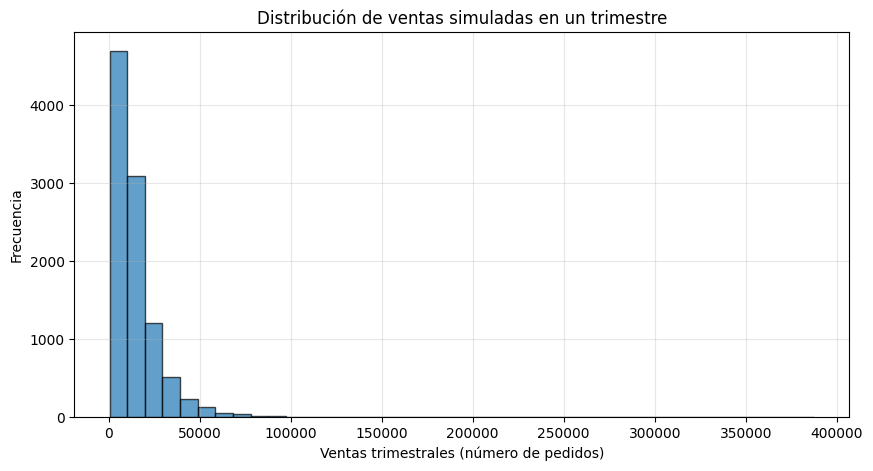

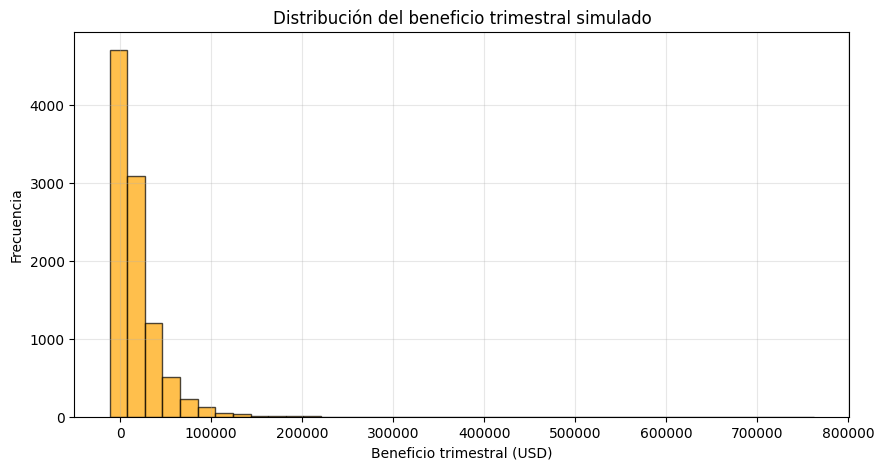

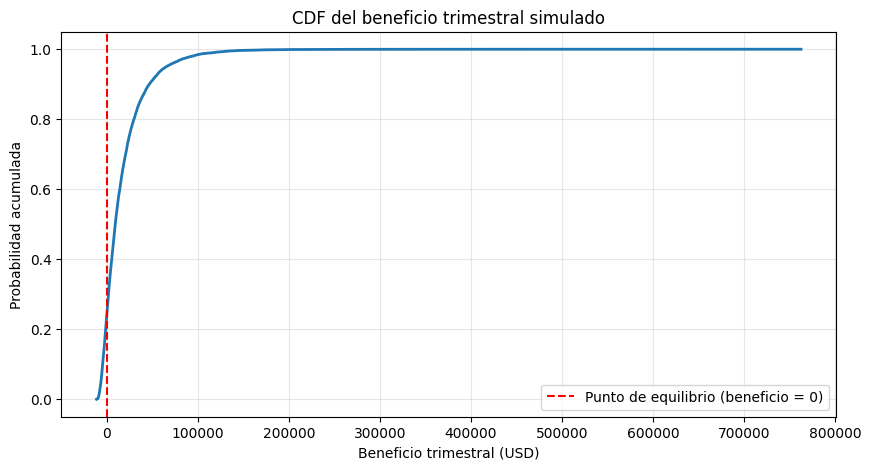

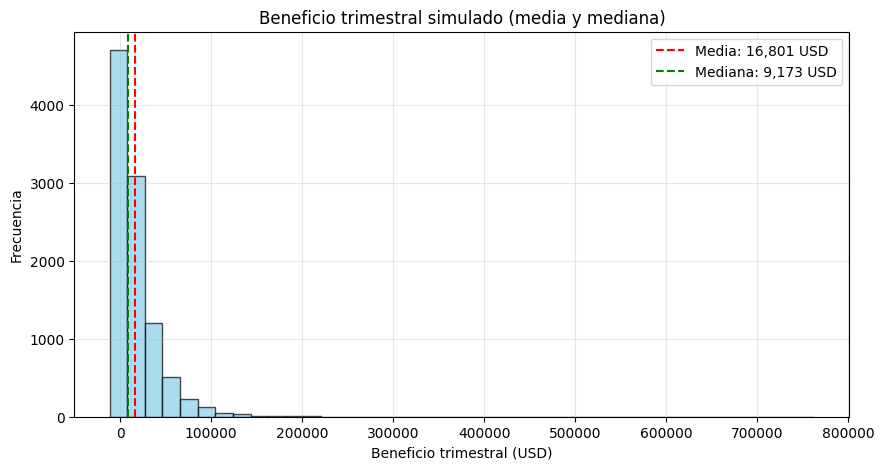

In [ ]:
# =========================================
# 1) Histograma de ventas trimestrales
# =========================================

plt.figure(figsize=(10,5))
plt.hist(ventas_trimestre_sim, bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribución de ventas simuladas en un trimestre")
plt.xlabel("Ventas trimestrales (número de pedidos)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

# =========================================
# 2) Histograma de beneficio trimestral
# =========================================

plt.figure(figsize=(10,5))
plt.hist(beneficio_trimestre_sim, bins=40, edgecolor='black', alpha=0.7, color='orange')
plt.title("Distribución del beneficio trimestral simulado")
plt.xlabel("Beneficio trimestral (USD)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

# =========================================
# 3) CDF del beneficio trimestral
# =========================================

benef_sorted = np.sort(beneficio_trimestre_sim)
cdf = np.arange(1, len(beneficio_trimestre_sim)+1) / len(beneficio_trimestre_sim)

plt.figure(figsize=(10,5))
plt.plot(benef_sorted, cdf, linewidth=2)
plt.axvline(0, color='red', linestyle='--', label='Punto de equilibrio (beneficio = 0)')
plt.title("CDF del beneficio trimestral simulado")
plt.xlabel("Beneficio trimestral (USD)")
plt.ylabel("Probabilidad acumulada")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =========================================
# 4) Línea vertical en la media y mediana
# =========================================

benef_media = np.mean(beneficio_trimestre_sim)
benef_mediana = np.median(beneficio_trimestre_sim)

plt.figure(figsize=(10,5))
plt.hist(beneficio_trimestre_sim, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(benef_media, color='red', linestyle='--', label=f'Media: {benef_media:,.0f} USD')
plt.axvline(benef_mediana, color='green', linestyle='--', label=f'Mediana: {benef_mediana:,.0f} USD')
plt.title("Beneficio trimestral simulado (media y mediana)")
plt.xlabel("Beneficio trimestral (USD)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Matias R

In [ ]:
library(tidyverse)
library(lubridate)
# Cargar datasets
items <- read_csv("Dataset/olist_order_items_dataset.csv") %>%
  select(order_id, product_id, price, freight_value)

payments <- read_csv("Dataset/olist_order_payments_dataset.csv") %>%
  select(order_id, payment_value)

orders <- read_csv("Dataset/olist_orders_dataset.csv") %>%
  select(order_id, order_purchase_timestamp)


# Cruzar las 3 tablas por order_id
df_final <- items %>%
  inner_join(payments, by = "order_id") %>%
  inner_join(orders, by = "order_id")

set.seed(123)

#los costos d envio los cubre todos el comprador por eso los incluimos en el precio

# Generamos un porcentaje de costo entre 0.5 y 0.8 para cada product_id
porcentaje_producto <- df_final %>%
  distinct(product_id) %>%          # una fila por producto
  mutate(pct_costo = runif(n(), 0.5, 0.8))

df_final <- df_final %>%
  left_join(porcentaje_producto, by = "product_id") %>%
  mutate(costo = price * pct_costo)

str(df_final)
# Aseguramos que price, freight_value, payment_value y costo sean numéricos
df_final <- df_final %>%
  mutate(
    price = as.numeric(price),
    freight_value = as.numeric(freight_value),
    payment_value = as.numeric(payment_value),
    costo = as.numeric(costo),
    order_purchase_timestamp = as.Date(order_purchase_timestamp) #dejar solo fecha
  )
# Verificar NAs
sum(is.na(df_final$order_id))
sum(is.na(df_final$order_purchase_timestamp))
sum(is.na(df_final$price))
sum(is.na(df_final$freight_value))
sum(is.na(df_final$payment_value))
sum(is.na(df_final$costo))

df_final <- df_final %>%
  mutate(month = floor_date(order_purchase_timestamp, "month"))
#Contar órdenes mensuales (serie de demanda)

demanda_mensual <- df_final %>%
  group_by(month) %>%
  summarise(ordenes = n()) %>%
  arrange(month)

#Costo prommedio mensual
costo_mensual <- df_final %>%
  group_by(month) %>%
  summarise(costo_promedio = mean(costo, na.rm = TRUE))

#Margen promedio mensual
margen_mensual <- df_final %>%
  group_by(month) %>%
  summarise(
    ingreso_prom = mean(payment_value, na.rm = TRUE),
    costo_prom   = mean(costo, na.rm = TRUE),
    margen_prom  = ingreso_prom - costo_prom
  )

#INTERPOLACION

# Elegimos un mes a eliminar
mes_faltante <- as.Date("2018-04-01")

# Creamos serie con el mes eliminado
demanda_mensual_incompleta <- demanda_mensual %>%
  filter(month != mes_faltante)

# Convertimos month a índice numérico
demanda_mensual_incompleta <- demanda_mensual_incompleta %>%
  mutate(idx = as.numeric(difftime(month, min(month), units = "days")) / 30.44)
# Aproximación de meses

# Spline cúbica
ordenes_spline <- spline(
  x = demanda_mensual_incompleta$idx,
  y = demanda_mensual_incompleta$ordenes,
  xout = as.numeric(difftime(mes_faltante, min(demanda_mensual$month), units = "days")) / 30.44
)$y

ordenes_spline

SyntaxError: invalid syntax (ipython-input-2312272450.py, line 4)

## Juan Inventos


In [ ]:
Punto de Equilibrio






# Vamos a tener en cuenta que el envio es terciarizado y lo amortiza todo el comprador, no significa costo ni ganancia para la empresa.
# Los costos de una empresa de e-commerce en Brasil incluyen gastos de registro, impuestos, infraestructura web, marketing y costos variables
# como fabricación, empaquetado y envío.

# Inversion Inicial = elegir en funcion a las ganancias (algo que tenga sentido)
# Costos Fijos = lo mismo

VPN del proyecto  (cero en funciones)

I0  <- inversion_inicial
cv  <- costo_variable_porcentaje  # ej: 0.35
CF  <- costo_fijo_mensual         # ej: 20000
T   <- length(ventas)             # meses proyectados

# función del VPN en términos de la tasa r
VPN <- function(r){
  flujos <- ventas*(1-cv) - CF                     # flujo neto por mes
  sum(flujos / (1+r)^(1:T)) - I0                   # ∑ flujos descontados - inversión
}



# TIR → raíz que hace VPN=0
TIR <- uniroot(VPN, interval=c(0,1))$root
TIR

## Buscamos raices pero con metodo de biseccion (incluido dentrro de uniroot)



biseccion_TIR <- function(f, a, b, tol = 1e-6, max_iter = 1000) {

  fa <- f(a)
  fb <- f(b)

  # verificamos que haya cambio de signo
  if (fa * fb > 0) stop("No hay certeza de raíz en el intervalo dado")

  for (i in 1:max_iter) {
    m <- (a + b) / 2        # punto medio
    fm <- f(m)

    if (abs(fm) < tol) {
      cat("Convergió en", i, "iteraciones\n")
      return(m)             # raíz encontrada
    }

    # decide en qué subintervalo seguir
    if (fa * fm < 0) {
      b <- m
      fb <- fm
    } else {
      a <- m
      fa <- fm
    }
  }

  warning("No convergió — aumentar iteraciones o mejorar intervalo")
  return((a + b) / 2)
}


#para anualizarlo ya que usamos periodos mensuales

TIR_anual <- (1 + TIR_biseccion)^12 - 1

## Simulacion

In [ ]:
Lo importante es extraer el comportamiento histórico para usarlo en el futuro.

beneficios_hist  # ganancias por mes durante 24 meses (o más)
costos_fijos
costos_variables

media     <- mean(beneficios_hist)
desvio    <- sd(beneficios_hist)
crec      <- diff(beneficios_hist) / lag(beneficios_hist)   # crecimiento por mes
media_crec<- mean(crec, na.rm=TRUE)
sd_crec   <- sd(crec, na.rm=TRUE)
#Esto nos dice cómo evoluciona la empresa en el tiempo.

Paso 2 — Elegir una distribución para simular el futuro
Hay 3 enfoques válidos para Monte Carlo:

| Modelo                                                       | Ventaja                                        | Útil cuando                        |
| ------------------------------------------------------------ | ---------------------------------------------- | ---------------------------------- |
| **Normal con media/varianza histórica**                      | Simple y realista si variación no es explosiva | Beneficios sin colas extremas      |


Modelo de crecimiento con ruido (Monte Carlo temporal)

Gan(t+1) = Gan(t) × (1+α+ϵt​)

α = crecimiento medio mensual
𝜖𝑡 ∼ 𝑁(0,𝜎2) = ruido aleatorio del mercado


Supongamos que queremos simular 36 meses futuros, con 5000 trayectorias Monte Carlo.

set.seed(2024)

# Parámetros estimados del pasado
gan <- beneficios_hist
crec <- diff(gan) / lag(gan)
alpha <- mean(crec, na.rm = TRUE)
sigma <- sd(crec, na.rm = TRUE)

# Parámetros de simulación
n_sim   <- 5000    # número de trayectorias
horiz   <- 36      # meses futuros
ini     <- tail(gan, 1)  # último valor real observado

# Matriz donde guardaremos simulaciones
sim <- matrix(NA, nrow=horiz, ncol=n_sim)

for(j in 1:n_sim){
    sim[1,j] <- ini * (1 + rnorm(1, alpha, sigma))
    for(t in 2:horiz){
        sim[t,j] <- sim[t-1,j] * (1 + rnorm(1, alpha, sigma))
    }
}

Si queremos tambien considerar los costos fijos y variables creo que asi funcionaria

CF <- 20000              # ejemplo
CV_pct <- 0.40           # ej. 40% del beneficio

flujos <- sim * (1-CV_pct) - CF


RESULTADOS

prob_supervivencia <- mean(colSums(flujos) > 0)
prob_supervivencia

traj_media <- apply(sim,1,mean)
traj_p5    <- apply(sim,1,quantile,0.05)
traj_p95   <- apply(sim,1,quantile,0.95)



